# Data Pre-processing

Constants:

In [1]:
import zipfile
with zipfile.ZipFile("data.zip","r") as zip_ref:
    zip_ref.extractall("")
seed = 0

conversion = "RGB"
# conversion = "L"

Load the data into separate lists

In [2]:
import os
import numpy as np
from PIL import ImageOps, Image

healthy_dir = 'Brain Tumor Data Set/Brain Tumor Data Set/Healthy/'
cancer_dir = 'Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/'

def getImages(dir):
  image_list = []
  file_list = os.listdir(dir)
  print(file_list)
  for file in file_list:
    image_list.append(Image.open(os.path.join(dir,file)))

  return image_list
    

In [3]:
healthy_images = getImages(healthy_dir)
cancer_images = getImages(cancer_dir)


targets = []
for i in range(len(os.listdir(cancer_dir))):
  targets.append('cancer')
for i in range(len(os.listdir(healthy_dir))):
  targets.append('healthy')

for i in range(len(healthy_images)):
  healthy_images[i] = healthy_images[i].convert(conversion)

for i in range(len(cancer_images)):
  cancer_images[i] = cancer_images[i].convert(conversion)

['Not Cancer  (1527).jpg', 'Not Cancer  (1398).jpg', 'Not Cancer  (703).jpg', 'Not Cancer  (813).jpg', 'Not Cancer  (899).jpg', 'Not Cancer  (217).jpg', 'Not Cancer  (1825).jpg', 'Not Cancer  (857).jpg', 'Not Cancer  (290).jpg', 'Not Cancer  (467).jpg', 'Not Cancer  (1187).jpg', 'Not Cancer  (724).jpg', 'Not Cancer  (687).jpg', 'Not Cancer  (1468).jpg', 'Not Cancer  (29).jpg', 'Not Cancer  (1635).jpg', 'Not Cancer  (232).jpg', 'Not Cancer  (1327).jpg', 'Not Cancer  (1717).jpg', 'Not Cancer  (458).jpg', 'Not Cancer  (1641).jpg', 'Not Cancer  (1066).jpg', 'Not Cancer  (650).jpg', 'Not Cancer  (302).jpg', 'Not Cancer  (256).jpg', 'Not Cancer  (1447).jpg', 'Not Cancer  (150).jpg', 'Not Cancer  (1463).jpg', 'Not Cancer  (851).jpg', 'Not Cancer  (110).jpg', 'Not Cancer  (977).jpg', 'Not Cancer  (820).jpg', 'Not Cancer  (1520).jpg', 'Not Cancer  (1038).jpg', 'Not Cancer  (288).jpg', 'Not Cancer  (763).jpg', 'Not Cancer  (1133).jpg', 'Not Cancer  (1034).jpg', 'Not Cancer  (1710).jpg', 'Not Can

Normalize the image sizes by the median size

In [4]:
all_images = cancer_images + healthy_images

all_images[0].size[0]

dim_one_list = []
dim_two_list = []
for pic in all_images:
  dim_one_list.append(pic.size[0])
  dim_two_list.append(pic.size[1])

dim_one_list.sort()
dim_two_list.sort()

median1 = dim_one_list[(int)(len(dim_one_list)/2)]
median2 = dim_two_list[(int)(len(dim_two_list)/2)]

for i in range(len(all_images)):
  all_images[i] = all_images[i].resize((median1,median2))

In [5]:
for i in range(len(all_images)):
  all_images[i] = np.array(all_images[i])
images_2d = all_images
# Cannot normalize image pixel values due to insufficient RAM for the process
# normalized_images = np.divide(normalized_images, 255.0)

In [6]:
print(max(images_2d[0][0][0]))

23


In [7]:
print(len(images_2d))
print(len(images_2d[0]))
print(len(images_2d[0][2]))
for i in range(len(images_2d)):
  if len(images_2d[i][0][0]) != 3:
    print(len(images_2d[i][0][0]))

print(len(images_2d[0][2][4]))

images_2d = np.array(images_2d)
images_2d = images_2d.reshape(len(images_2d), median1 * median2 * 3)



4600
338
283
3


In [8]:
print(np.shape(images_2d))
print(median1)
print(median2)

(4600, 286962)
283
338


# Data Exploration

## Visualizations

### Cancer Array

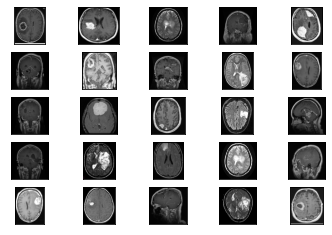

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(5, 5)
limit = 25
for index, element in zip(range(limit), cancer_images):
    ax[index // 5][index % 5].imshow(element)
    ax[index // 5][index % 5].get_xaxis().set_visible(False)
    ax[index // 5][index % 5].get_yaxis().set_visible(False)
fig.show()

### Healthy Array

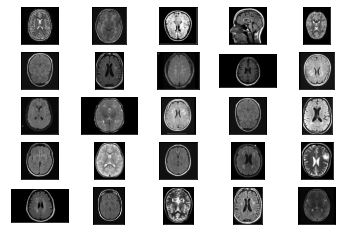

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(5, 5)
limit = 25
for index, element in zip(range(limit), healthy_images):
    ax[index // 5][index % 5].imshow(element)
    ax[index // 5][index % 5].get_xaxis().set_visible(False)
    ax[index // 5][index % 5].get_yaxis().set_visible(False)
fig.show()

# Simplification of Components (important for KNN and Naive Bayes)

## Determine Number of Components Needed

In [ ]:
features = images_2d
print(features.shape)

(4600, 286962)


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def pcaOnSubset(features, state, variance_threshold):

  pca = PCA().fit(train_test_split(features, train_size=features.shape[0]//8, shuffle=True, random_state=state)[0])

  fig, ax1 = plt.subplots(figsize = (20,5))
  variance_explained = []
  for i in range(len(pca.explained_variance_ratio_)):
    variance_explained.append(pca.explained_variance_ratio_[0:i].sum())


  ax1.plot(np.arange(1, len(variance_explained)+1), variance_explained, color='tab:blue', label='Variance Explained by PCA Components')
  plt.title('Variance Explained vs PCA Components Used')
  plt.xlabel('Number of PCA Components')
  plt.ylabel('Variance Explained')
  plt.show()

  for i in range(len(variance_explained)):
    if variance_explained[i] > variance_threshold:
      return i
  return 0

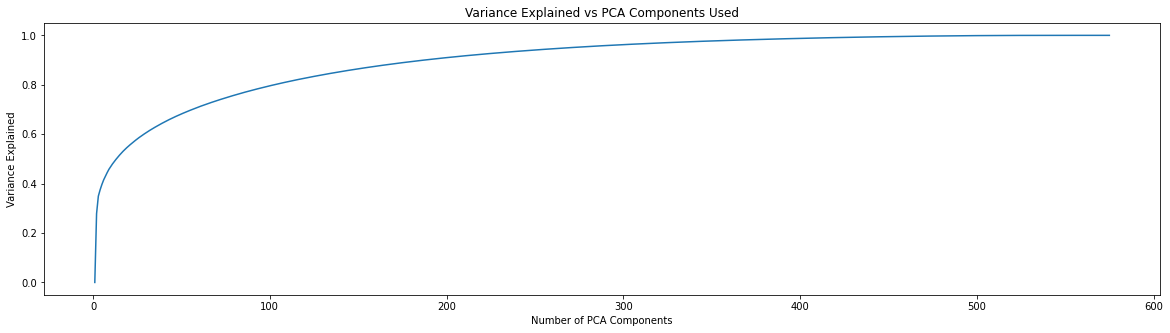

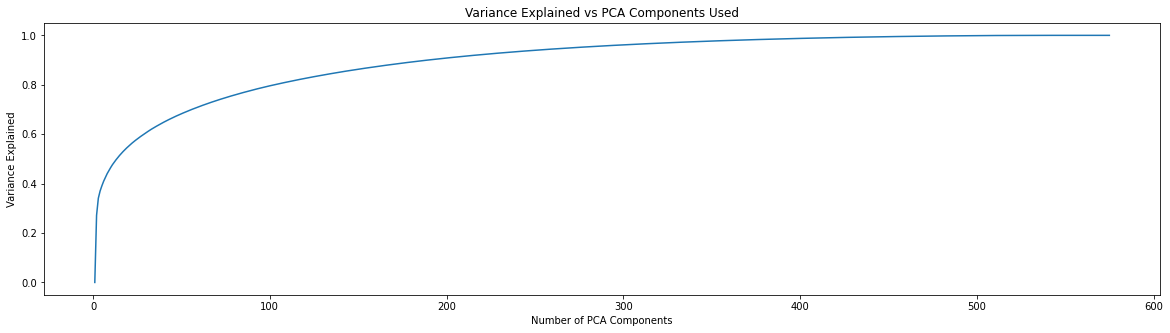

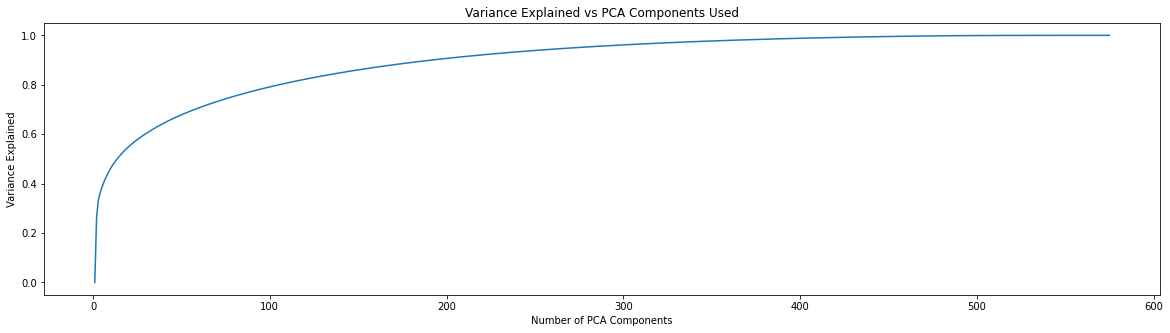

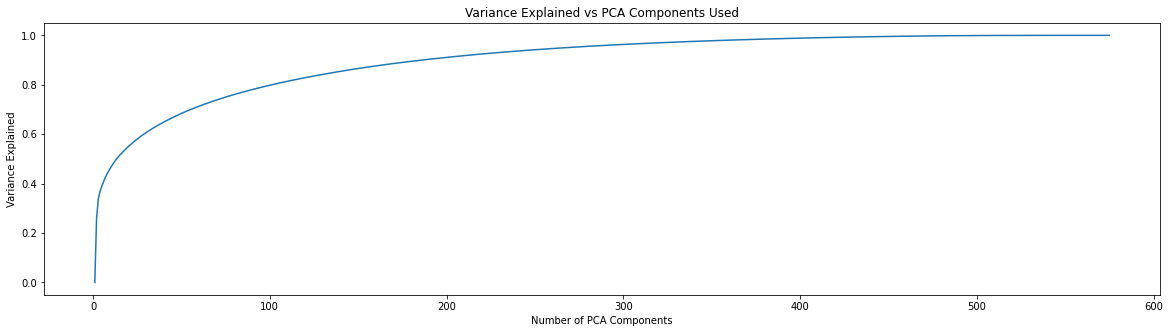

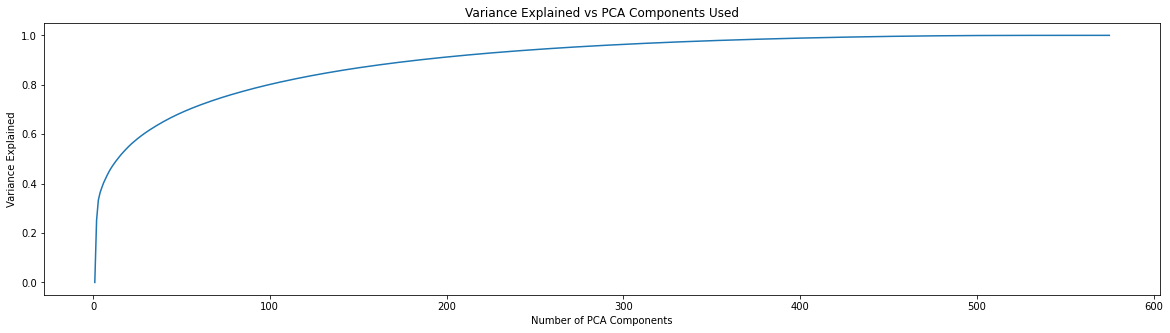

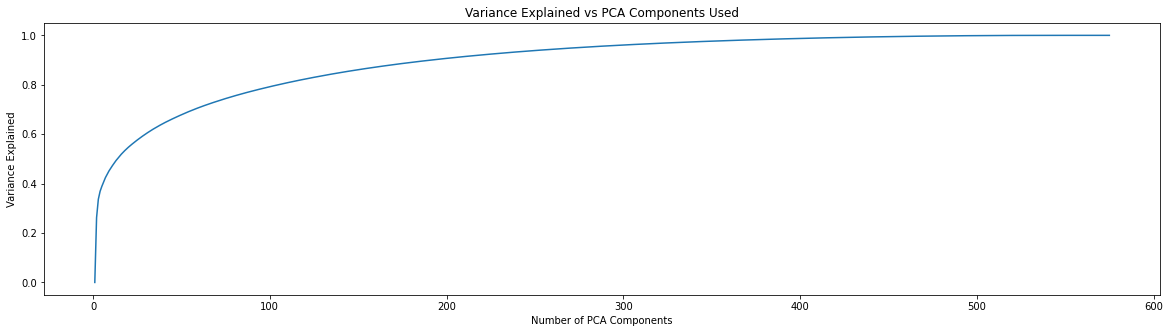

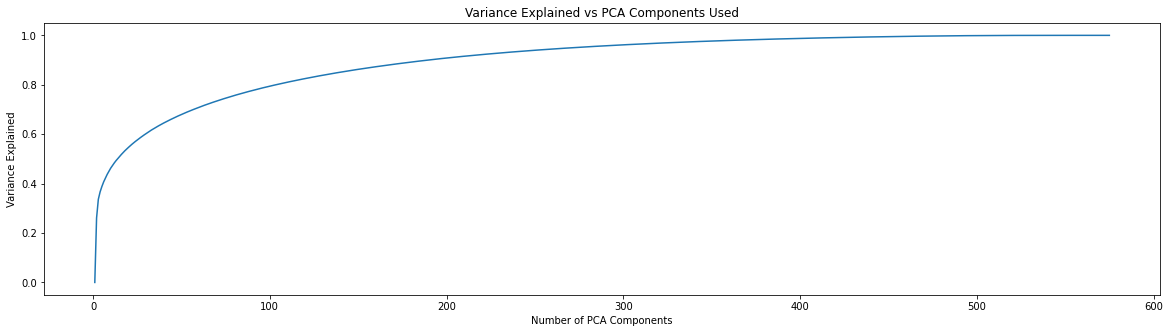

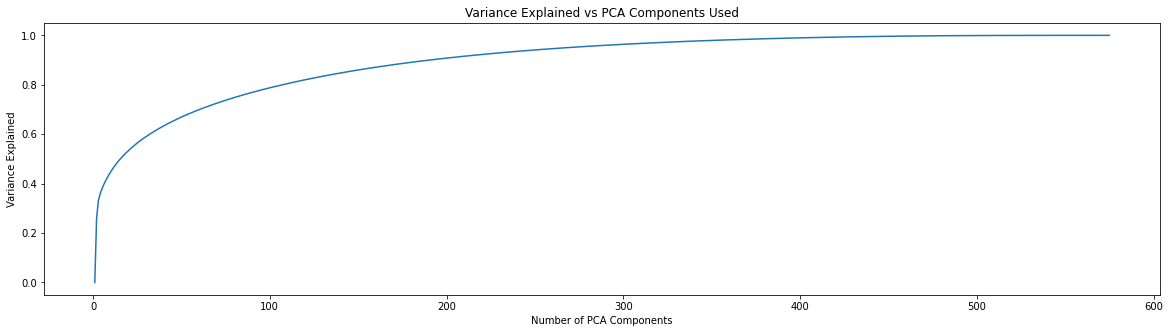

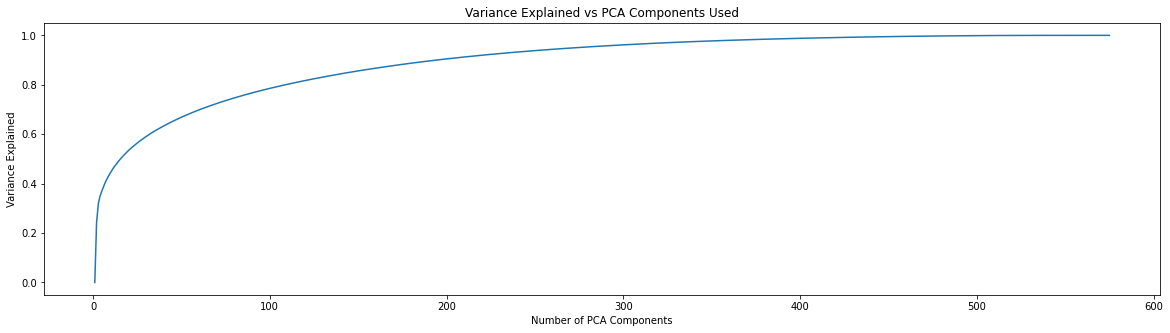

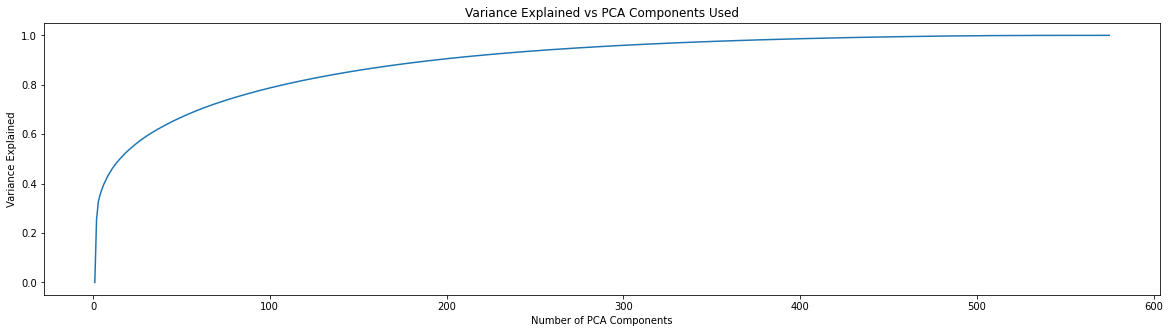

[269, 271, 272, 267, 266, 273, 271, 267, 272, 276]
270.4


In [ ]:
needed_components = []
threshold = 0.95
for i in range(10):
  needed_components.append(pcaOnSubset(features, i, threshold))
  print(i, "th test: ", needed_components[i])
  print("============================================================================================================================================================")

print(needed_components)
print(np.average(needed_components))

# Non-CNN Model Development

### summaryStatistics(targets, predictions) Function

In [37]:
from sklearn.metrics import confusion_matrix
#stat names are given by index
def summaryStatistics(targets, predictions):
  confusion_mat = confusion_matrix(targets, predictions, labels=['cancer', 'healthy'])
  # Therefore [0][0] is true positive for cancer
  # [0][1] is false negative (predicted healthy, have cancer)
  # [1][0] is false positive (predicted cancer, is healthy)
  # [1][1] is true negative (predicted healthy, is healthy)
  summaryStatistics = []
  stat_name = []

  summaryStatistics.append(confusion_mat[0][0])
  stat_name.append('True Positive')
  summaryStatistics.append(confusion_mat[0][1])
  stat_name.append('False Negative')
  summaryStatistics.append(confusion_mat[1][0])
  stat_name.append('False Positive')
  summaryStatistics.append(confusion_mat[1][1])
  stat_name.append('True Negative')

  conditionPositive = confusion_mat[0][0] + confusion_mat[0][1]
  conditionNegative = confusion_mat[1][1] + confusion_mat[1][0]

  summaryStatistics.append((confusion_mat[0][0] + confusion_mat[1][1]) / len(targets))
  stat_name.append('Accuracy')
  summaryStatistics.append(confusion_mat[0][0] / (confusion_mat[0][0] + confusion_mat[1][0]))
  stat_name.append('Precision')

  summaryStatistics.append(confusion_mat[0][0] / conditionPositive)
  stat_name.append('Sensitivity (True Positive Rate)')
  summaryStatistics.append(confusion_mat[1][1] / conditionNegative)
  stat_name.append('Specificity (True Negative Rate)')
  summaryStatistics.append(confusion_mat[0][1] / conditionPositive)
  stat_name.append('False Negative Rate')
  summaryStatistics.append(confusion_mat[1][0] / conditionNegative)
  stat_name.append('False Positive Rate')
  summaryStatistics.append(max(targets.count('cancer'), targets.count('healthy')) / len(targets))
  stat_name.append('Null Error Rate')
  
  return (summaryStatistics, stat_name)

### Random Forest Classifier

In [10]:
from matplotlib.rcsetup import validate_dpi
import matplotlib.pyplot as plt
import sklearn.model_selection as skms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
#Constants for training and testing
# Used for consistency of validation part and testing (don't want to test on data that was trained/validated on)
SPLIT_NUMBER = 5
TEST_SIZE = 0.30

MAX_DEPTH = [2, 4, 8, 16, 32, 64, 128, 256] #Used for limiting the number of max leaves
# MAX_DEPTH = [2, 4, 8, 16, 32, 64] 

features = images_2d

In [ ]:
from matplotlib.rcsetup import validate_dpi
import matplotlib.pyplot as plt
import sklearn.model_selection as skms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

BEST_DEPTH_NUM = 0

features_train, features_test, targets_train, targets_test = skms.train_test_split(features, targets, random_state = seed, test_size=TEST_SIZE)

train_accuracy = np.zeros(len(MAX_DEPTH))
validation_accuracy = np.zeros(len(MAX_DEPTH))

for m,max_param in enumerate(MAX_DEPTH):
  # Random Forest
  clf = RandomForestClassifier(max_leaf_nodes=max_param, random_state=seed)
  # clf = RandomForestClassifier(max_depth=max_param, random_state=seed)
  
  crossValidator = StratifiedKFold(n_splits=SPLIT_NUMBER, random_state=seed, shuffle=True)
  cv_results = cross_validate(clf, features_train, targets_train, cv=crossValidator, scoring='accuracy', return_train_score=True)

  train_accuracy[m] = cv_results['train_score'].mean()
  validation_accuracy[m] = cv_results['test_score'].mean()

fig, ax1 = plt.subplots(figsize = (20,5))


ax1.plot(MAX_DEPTH, train_accuracy, color='tab:orange', label='Accuracy on Training set')
ax1.plot(MAX_DEPTH, validation_accuracy, color = 'tab:blue', label='Accuracy on Validation set')
plt.title('Prediction Accuracy of Medical Images Using Random Forest Classifier vs. Maximum Leaf Number')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Max Leaf Number')
plt.ylabel('Accuracy')
ax1.set_ylim(validation_accuracy.min())
plt.show()
print()


bestChoiceIndex = 0
for n, max_param in enumerate(MAX_DEPTH):
  if (validation_accuracy[n] > validation_accuracy[bestChoiceIndex]):
    bestChoiceIndex = n

BEST_DEPTH_NUM = MAX_DEPTH[bestChoiceIndex]
print(BEST_DEPTH_NUM, ": Validation Accuracy for optimal k: ", validation_accuracy[bestChoiceIndex])
print(validation_accuracy)

In [11]:
# Values found from validation (don't want to have to rerun validation unless absolutely needed)
# Use for actual max depth
BEST_DEPTH_NUM = 16
# Use when testing with max node number
#BEST_DEPTH_NUM = 128

In [17]:
features_train, features_test, targets_train, targets_test = skms.train_test_split(features, targets, random_state = seed, test_size=TEST_SIZE)

clf = RandomForestClassifier(max_depth=(int)(BEST_DEPTH_NUM), random_state=seed).fit(features_train, targets_train)
#clf = RandomForestClassifier(max_leaf_nodes=(int)(BEST_DEPTH_NUM), random_state=seed).fit(features_train, targets_train)

print("Model test results for concentration of:")
print("Predication Accuracy of model: ", metrics.accuracy_score(targets_test, clf.predict(features_test)))

print("Max Depth of trees: ", (int)(BEST_DEPTH_NUM))
print()


Model test results for concentration of:
Predication Accuracy of model:  0.9702898550724638
Max Depth of trees:  16



In [18]:
print(targets_test.count("cancer"))
print(targets_test.count("healthy"))
print(len(targets_test))

print(clf.predict(features_test))

766
614
1380
['cancer' 'healthy' 'cancer' ... 'cancer' 'healthy' 'cancer']


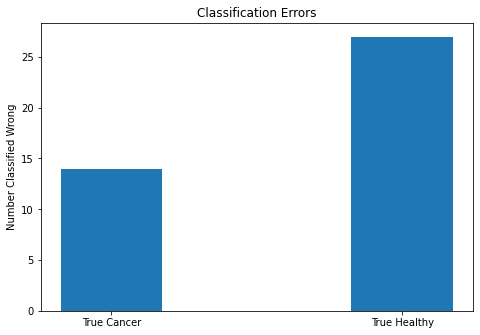

In [19]:
cancerPredictedWrong = 0
healthyPredictedWrong = 0
cancerPredictedRight = 0
healthyPredictedRight = 0

predictions = clf.predict(features_test)
for i in range(len(predictions)):
  if predictions[i] != targets_test[i]:
    if targets_test[i] == 'cancer':
      cancerPredictedWrong = cancerPredictedWrong + 1
    if targets_test[i] == 'healthy':
      healthyPredictedWrong = healthyPredictedWrong + 1
  else:
    if targets_test[i] == 'cancer':
      cancerPredictedRight = cancerPredictedRight + 1
    if targets_test[i] == 'healthy':
      healthyPredictedRight = healthyPredictedRight + 1

ind = ['True Cancer', 'True Healthy']
width = 0.35
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(ind, (cancerPredictedWrong, healthyPredictedWrong), width)
ax.set_ylabel('Number Classified Wrong')
ax.set_title('Classification Errors')
ax.set_xticks(ind)
plt.show()

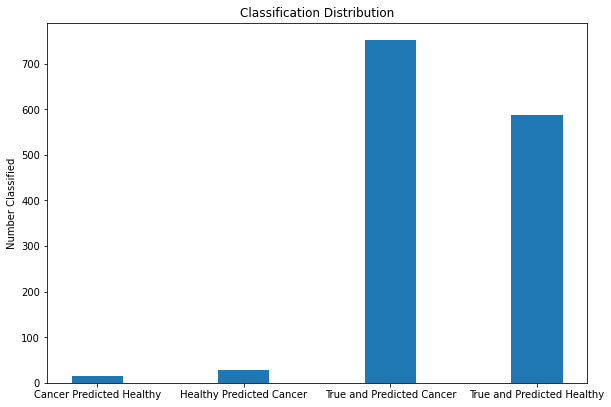

In [20]:
ind = ['Cancer Predicted Healthy', 'Healthy Predicted Cancer', 'True and Predicted Cancer', 'True and Predicted Healthy']
width = 0.35
fig = plt.figure(figsize=(7.5, 5.0))
ax = fig.add_axes([0,0,1,1])
ax.bar(ind, (cancerPredictedWrong, healthyPredictedWrong, cancerPredictedRight, healthyPredictedRight), width)
ax.set_ylabel('Number Classified')
ax.set_title('Classification Distribution')
ax.set_xticks(ind)
plt.show()

In [21]:
confusion_mat = confusion_matrix(targets_test, predictions, labels=['cancer', 'healthy'])
(stats, labels) = summaryStatistics(targets_test, predictions)
for i in range(len(stats)):
  print(labels[i], ': ', stats[i])

True Positive :  752
False Negative :  14
False Positive :  27
True Negative :  587
Accuracy :  0.9702898550724638
Precision :  0.9653401797175867
Sensitivity (True Positive Rate) :  0.9817232375979112
Specificity (True Negative Rate) :  0.9560260586319218
False Negative Rate :  0.018276762402088774
False Positive Rate :  0.043973941368078175
Null Error Rate :  0.5550724637681159


### KNN Classifier

In [ ]:
#Constants for training and testing
# Used for consistency of validation part and testing (don't want to test on data that was trained/validated on)
#SPLIT_NUMBER = 5
SPLIT_NUMBER = 2
TEST_SIZE = 0.80
features = images_2d

#MAX_K = 15
MAX_K = 15
K_Tested = np.arange(1, MAX_K + 1)

power=1 # Manhattan distance
#power = 2 # Euclidean Distance

print(K_Tested)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [ ]:
from matplotlib.rcsetup import validate_dpi
import matplotlib.pyplot as plt
import sklearn.model_selection as skms
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

BEST_K = 0

features_train, features_test, targets_train, targets_test = skms.train_test_split(features, targets, random_state = seed, test_size=TEST_SIZE)

train_accuracy = np.zeros(len(K_Tested))
validation_accuracy = np.zeros(len(K_Tested))

for m,k in enumerate(K_Tested):
  # KNN
  clf = KNeighborsClassifier(n_neighbors=k, p=power)
  
  crossValidator = StratifiedKFold(n_splits=SPLIT_NUMBER, random_state=seed, shuffle=True)
  cv_results = cross_validate(clf, features_train, targets_train, cv=crossValidator, scoring='accuracy', return_train_score=True)

  train_accuracy[m] = cv_results['train_score'].mean()
  validation_accuracy[m] = cv_results['test_score'].mean()

fig, ax1 = plt.subplots(figsize = (20,5))


ax1.plot(K_Tested, train_accuracy, color='tab:orange', label='Accuracy on Training set')
ax1.plot(K_Tested, validation_accuracy, color = 'tab:blue', label='Accuracy on Validation set')
plt.title('Prediction Accuracy of Medical Images Using KNN Classifier vs. K Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('K')
plt.ylabel('Accuracy')
ax1.set_ylim(validation_accuracy.min())
plt.show()
print()


bestChoiceIndex = 0
for n, trees in enumerate(K_Tested):
  if (validation_accuracy[n] > validation_accuracy[bestChoiceIndex]):
    bestChoiceIndex = n

BEST_K = K_Tested[bestChoiceIndex]
print(BEST_K, ": Validation Accuracy for optimal k: ", validation_accuracy[bestChoiceIndex])
print(validation_accuracy)

### Naive Bayes Classifier

In [ ]:
#Constants for training and testing
# Used for consistency of validation part and testing (don't want to test on data that was trained/validated on)
TEST_SIZE = 0.55

features = images_2d

In [ ]:
from matplotlib.rcsetup import validate_dpi
import matplotlib.pyplot as plt
import sklearn.model_selection as skms
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB

features_train, features_test, targets_train, targets_test = skms.train_test_split(features, targets, random_state = seed, test_size=TEST_SIZE)

clf = GaussianNB().fit(features_train, targets_train)

print("Model test results for concentration of:")

print()


# CNN

Model preparation enables the deterministic function in tensorflow, which gives determinism at a large efficieny cost due to limitations on multithreading

## Model Preparation

### summaryStatistics(targets, predictions) Function

In [38]:
from sklearn.metrics import confusion_matrix
#stat names are given by index
def summaryStatistics(targets, predictions):
  confusion_mat = confusion_matrix(targets, predictions, labels=['cancer', 'healthy'])
  # Therefore [0][0] is true positive for cancer
  # [0][1] is false negative (predicted healthy, have cancer)
  # [1][0] is false positive (predicted cancer, is healthy)
  # [1][1] is true negative (predicted healthy, is healthy)
  summaryStatistics = []
  stat_name = []

  summaryStatistics.append(confusion_mat[0][0])
  stat_name.append('True Positive')
  summaryStatistics.append(confusion_mat[0][1])
  stat_name.append('False Negative')
  summaryStatistics.append(confusion_mat[1][0])
  stat_name.append('False Positive')
  summaryStatistics.append(confusion_mat[1][1])
  stat_name.append('True Negative')

  conditionPositive = confusion_mat[0][0] + confusion_mat[0][1]
  conditionNegative = confusion_mat[1][1] + confusion_mat[1][0]

  summaryStatistics.append((confusion_mat[0][0] + confusion_mat[1][1]) / len(targets))
  stat_name.append('Accuracy')
  summaryStatistics.append(confusion_mat[0][0] / (confusion_mat[0][0] + confusion_mat[1][0]))
  stat_name.append('Precision')

  summaryStatistics.append(confusion_mat[0][0] / conditionPositive)
  stat_name.append('Sensitivity (True Positive Rate)')
  summaryStatistics.append(confusion_mat[1][1] / conditionNegative)
  stat_name.append('Specificity (True Negative Rate)')
  summaryStatistics.append(confusion_mat[0][1] / conditionPositive)
  stat_name.append('False Negative Rate')
  summaryStatistics.append(confusion_mat[1][0] / conditionNegative)
  stat_name.append('False Positive Rate')
  summaryStatistics.append(max(targets.count('cancer'), targets.count('healthy')) / len(targets))
  stat_name.append('Null Error Rate')
  
  return (summaryStatistics, stat_name)

### Pre-Processing (Saving into directoris)

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import tensorflow as tf
from keras import backend as K
import keras as keras
from keras.layers import *

seed = 0
TEST_SIZE = 0.15
# tf.random.set_seed(seed)
tf.keras.utils.set_random_seed(seed)
tf.config.experimental.enable_op_determinism()

# Given as fraction of whole data set
ACTUAL_VALIDATION_PART = 0.15

# Calculated as fraction of data set remaining after test portion removed
VALIDATION_SIZE = ACTUAL_VALIDATION_PART / (1.0 - TEST_SIZE)

CANCER_CLASS_NAME = 'Brain Tumor'
CLASS_HEALTHY_NAME = 'Healthy'

ROOT_DIRECTORY_NAME = 'data'
TEST_DIRECTORY_NAME = 'test'
VALIDATION_DIRECTORY_NAME = 'validation'
TRAIN_DIRECTORY_NAME = 'train'

In [2]:
import zipfile
from matplotlib.rcsetup import validate_dpi
import matplotlib.pyplot as plt

with zipfile.ZipFile("data.zip","r") as zip_ref:
    zip_ref.extractall("")

In [3]:
import os
import numpy as np

healthy_dir = 'Brain Tumor Data Set/Brain Tumor Data Set/Healthy/'
cancer_dir = 'Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/'

def getFileNames(dir):
  image_name_list = []
  file_list = os.listdir(dir)
  for file in file_list:
    image_name_list.append(os.path.join(dir,file))
  return image_name_list

features = getFileNames(cancer_dir) + getFileNames(healthy_dir)
print(features)

['Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (2309).jpg', 'Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (44).jpg', 'Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (706).jpg', 'Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1468).jpg', 'Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1005).jpg', 'Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (786).jpg', 'Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (551).jpg', 'Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1113).jpg', 'Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (2313).jpg', 'Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (302).jpg', 'Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1675).jpg', 'Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (806).jpg', 'Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1949).jpg', 'Brain Tumor Data Set/Brain Tum

In [4]:
targets = []
for i in range(len(os.listdir(cancer_dir))):
  targets.append('cancer')
for i in range(len(os.listdir(healthy_dir))):
  targets.append('healthy')
print(targets)

['cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer',

In [5]:
import sklearn.model_selection as skms
import shutil


features_train, features_test, targets_train, targets_test = skms.train_test_split(features, targets, random_state = seed, test_size=TEST_SIZE, shuffle=True)
features_train, features_validate, targets_train, targets_validate = skms.train_test_split(features_train, targets_train, random_state = seed, test_size=VALIDATION_SIZE, shuffle=True)

if not os.path.isdir(os.path.join(ROOT_DIRECTORY_NAME, TRAIN_DIRECTORY_NAME, CLASS_HEALTHY_NAME)):
  os.makedirs(os.path.join(ROOT_DIRECTORY_NAME, TRAIN_DIRECTORY_NAME, CLASS_HEALTHY_NAME))

if not os.path.isdir(os.path.join(ROOT_DIRECTORY_NAME, TRAIN_DIRECTORY_NAME, CANCER_CLASS_NAME)):
  os.makedirs(os.path.join(ROOT_DIRECTORY_NAME, TRAIN_DIRECTORY_NAME, CANCER_CLASS_NAME))

if not os.path.isdir(os.path.join(ROOT_DIRECTORY_NAME, VALIDATION_DIRECTORY_NAME, CLASS_HEALTHY_NAME)):
  os.makedirs(os.path.join(ROOT_DIRECTORY_NAME, VALIDATION_DIRECTORY_NAME, CLASS_HEALTHY_NAME))

if not os.path.isdir(os.path.join(ROOT_DIRECTORY_NAME, VALIDATION_DIRECTORY_NAME, CANCER_CLASS_NAME)):
  os.makedirs(os.path.join(ROOT_DIRECTORY_NAME, VALIDATION_DIRECTORY_NAME, CANCER_CLASS_NAME))

if not os.path.isdir(os.path.join(ROOT_DIRECTORY_NAME, TEST_DIRECTORY_NAME, CLASS_HEALTHY_NAME)):
  os.makedirs(os.path.join(ROOT_DIRECTORY_NAME, TEST_DIRECTORY_NAME, CLASS_HEALTHY_NAME))

if not os.path.isdir(os.path.join(ROOT_DIRECTORY_NAME, TEST_DIRECTORY_NAME, CANCER_CLASS_NAME)):
  os.makedirs(os.path.join(ROOT_DIRECTORY_NAME, TEST_DIRECTORY_NAME, CANCER_CLASS_NAME))


for i in range(len(features_train)):
  if targets_train[i] == 'healthy':
      shutil.copy(features_train[i], os.path.join(ROOT_DIRECTORY_NAME, TRAIN_DIRECTORY_NAME, CLASS_HEALTHY_NAME))
  else:
      shutil.copy(features_train[i], os.path.join(ROOT_DIRECTORY_NAME, TRAIN_DIRECTORY_NAME, CANCER_CLASS_NAME))

for i in range(len(features_validate)):
  if targets_validate[i] == 'healthy':
      shutil.copy(features_validate[i], os.path.join(ROOT_DIRECTORY_NAME, VALIDATION_DIRECTORY_NAME, CLASS_HEALTHY_NAME))
  else:
      shutil.copy(features_validate[i], os.path.join(ROOT_DIRECTORY_NAME, VALIDATION_DIRECTORY_NAME, CANCER_CLASS_NAME))

for i in range(len(features_test)):
  if targets_test[i] == 'healthy':
      shutil.copy(features_test[i], os.path.join(ROOT_DIRECTORY_NAME, TEST_DIRECTORY_NAME, CLASS_HEALTHY_NAME))
  else:
      shutil.copy(features_test[i], os.path.join(ROOT_DIRECTORY_NAME, TEST_DIRECTORY_NAME, CANCER_CLASS_NAME))

# Constants: 
#CANCER_CLASS_NAME = 'Brain Tumor'
#CLASS_HEALTHY_NAME = 'Healthy'

#ROOT_DIRECTORY_NAME = 'data'
#TEST_DIRECTORY_NAME = 'test'
#VALIDATION_DIRECTORY_NAME = 'validation'
#TRAIN_DIRECTORY_NAME = 'train'

In [6]:
print('Train:      ', len(features_train), '\tHealthy: ', targets_train.count('healthy'), '\tCancer: ', targets_train.count('cancer'))
print('Validation: ', len(features_validate), '\tHealthy: ', targets_validate.count('healthy'), '\tCancer: ', targets_validate.count('cancer'))
print('Test:       ', len(features_test), '\tHealthy: ', targets_test.count('healthy'), '\tCancer: ', targets_test.count('cancer'))

Train:       3220 	Healthy:  1485 	Cancer:  1735
Validation:  690 	Healthy:  304 	Cancer:  386
Test:        690 	Healthy:  298 	Cancer:  392


### Hyper Parameters

In [7]:
epochs = 15
batch_size = len(features_train) //100
validation_batch_size = len(features_validate) // 20
weights_file = 'weights1'

In [8]:
train_data_dir = os.path.join(ROOT_DIRECTORY_NAME, TRAIN_DIRECTORY_NAME) 
validate_data_dir = os.path.join(ROOT_DIRECTORY_NAME, VALIDATION_DIRECTORY_NAME) 
test_data_dir = os.path.join(ROOT_DIRECTORY_NAME, TEST_DIRECTORY_NAME) 

train_samples = len(features_train)
validate_samples = len(features_validate)
testSamples = len(features_test)

generator = ImageDataGenerator(rescale=1./255)

In [9]:
medianWidth = 338
medianHeight = 283

## Models

### Model 1 (Accuracy: 95.1%) (Simple CNN)



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 336, 281, 32)      896       
                                                                 
 activation (Activation)     (None, 336, 281, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 168, 140, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 166, 138, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 166, 138, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 83, 69, 32)       0         
 2D)                                                  

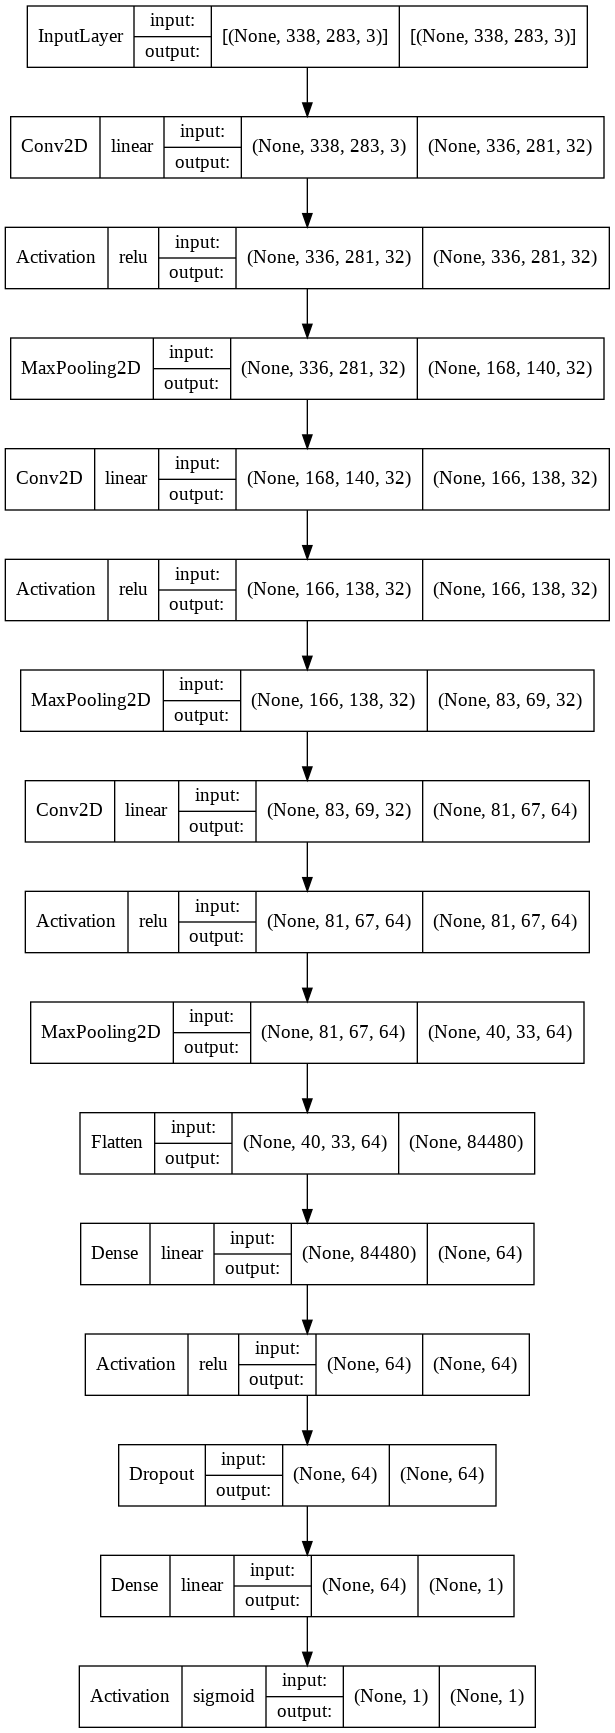

In [24]:
tf.keras.utils.set_random_seed(seed)
tf.config.experimental.enable_op_determinism()

if K.image_data_format() == 'channels_first':
    input_shape = (3, medianWidth, medianHeight)
else:
    input_shape = (medianWidth, medianHeight, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())
print()
tf.keras.utils.plot_model(model, show_shapes = True, show_layer_names = False, show_layer_activations=True, expand_nested=True)

### Model 2 (Accuracy: 94.8%) (Simple CNN)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 338, 283, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 169, 141, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 169, 141, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 84, 70, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 84, 70, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 42, 35, 128)     

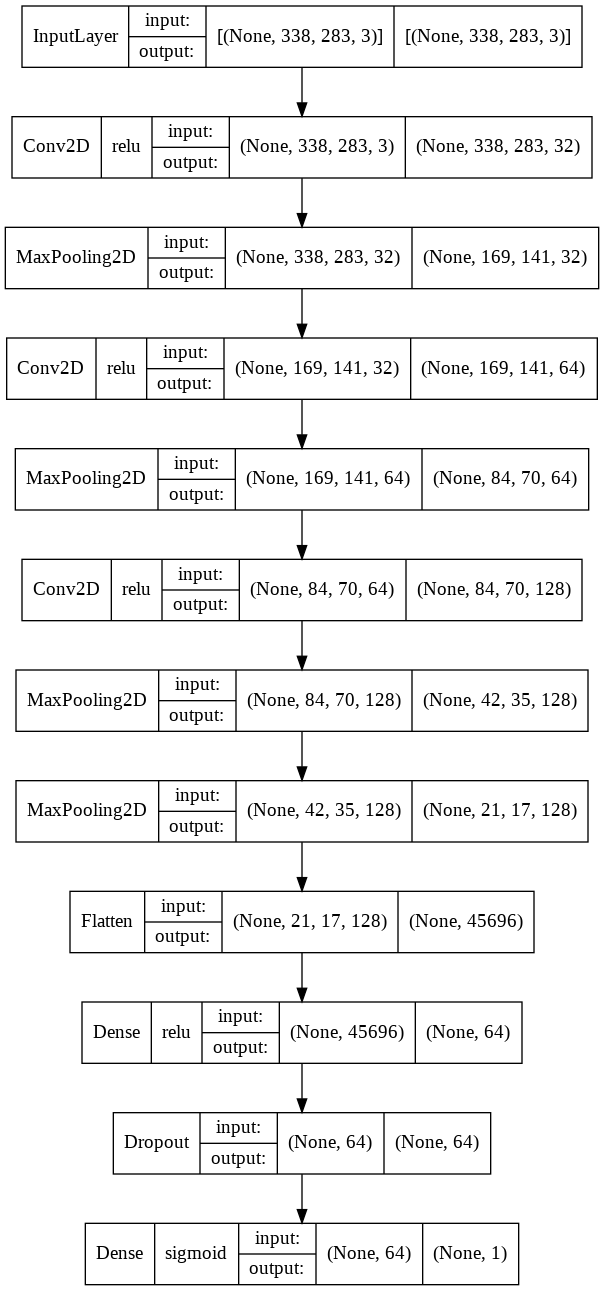

In [29]:
tf.keras.utils.set_random_seed(seed)
tf.config.experimental.enable_op_determinism()

if K.image_data_format() == 'channels_first':
    input_shape = (3, medianWidth, medianHeight)
else:
    input_shape = (medianWidth, medianHeight, 3)

model = Sequential()
model.add(InputLayer(input_shape=input_shape))
model.add(Conv2D(filters =32, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPool2D())

model.add(Conv2D(filters =64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPool2D())

model.add(Conv2D(filters =128, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPool2D())
model.add(MaxPool2D())


model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())
print()
tf.keras.utils.plot_model(model, show_shapes = True, show_layer_names = False, show_layer_activations=True, expand_nested=True)

### Model 3 (Accuracy: 95.9%) (Simple CNN)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 338, 283, 16)      448       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 169, 141, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 169, 141, 32)      4640      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 84, 70, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 84, 70, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 42, 35, 64)      

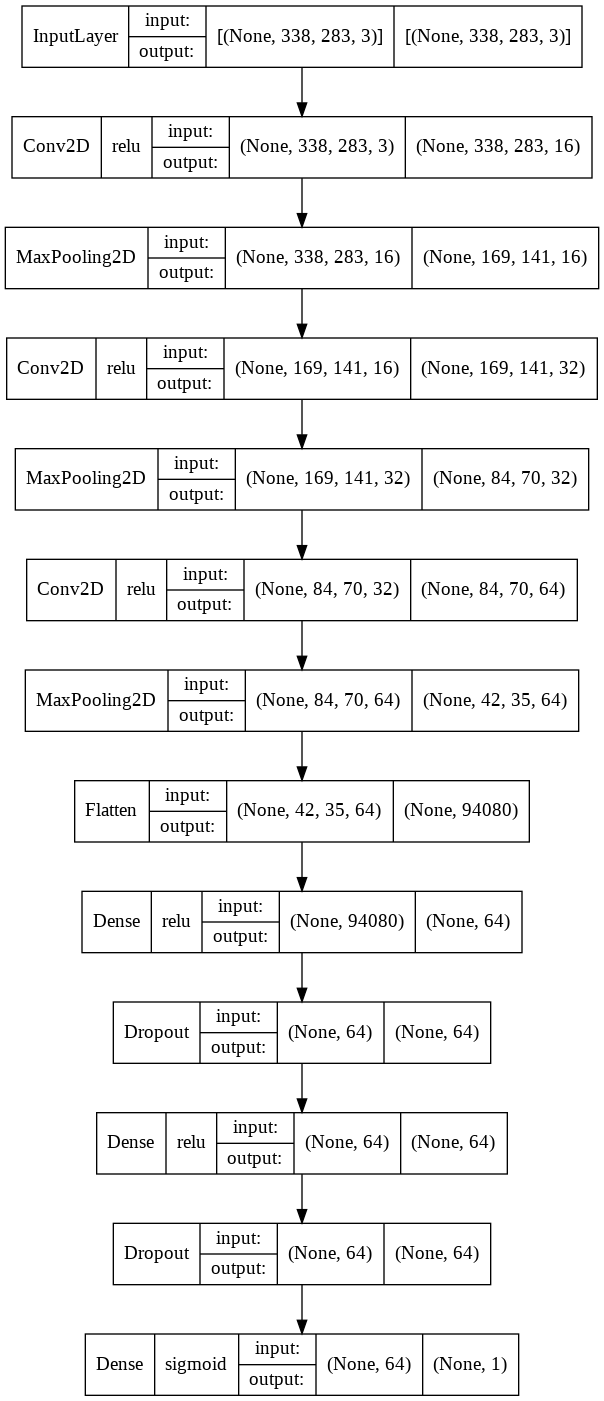

In [33]:
tf.keras.utils.set_random_seed(seed)
tf.config.experimental.enable_op_determinism()

if K.image_data_format() == 'channels_first':
    input_shape = (3, medianWidth, medianHeight)
else:
    input_shape = (medianWidth, medianHeight, 3)

model = Sequential()
model.add(InputLayer(input_shape=input_shape))
model.add(Conv2D(filters=16, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPool2D())

model.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPool2D())

model.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())
print()
tf.keras.utils.plot_model(model, show_shapes = True, show_layer_names = False, show_layer_activations=True, expand_nested=True)

### Model 4 (Accuracy: 95.9%) (Simple CNN)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 338, 283, 16)      448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 169, 141, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 169, 141, 32)      4640      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 84, 70, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 84, 70, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 42, 35, 64)      

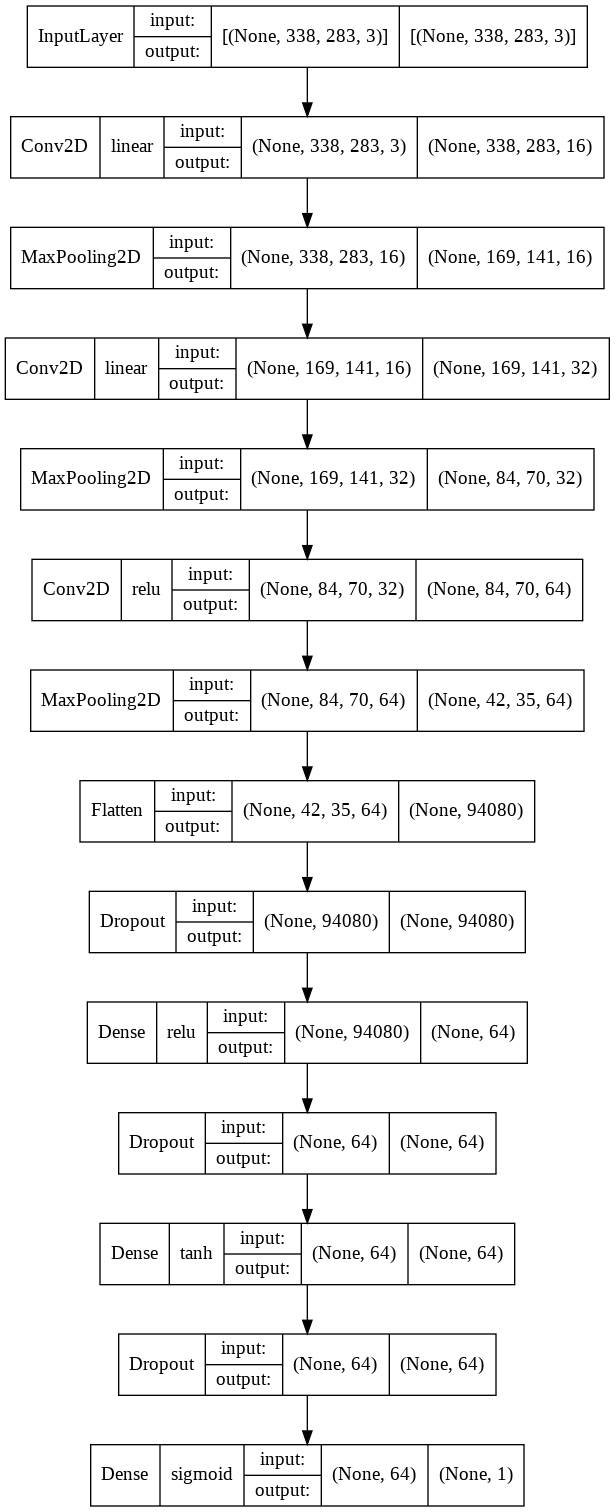

In [38]:
tf.keras.utils.set_random_seed(seed)
tf.config.experimental.enable_op_determinism()

if K.image_data_format() == 'channels_first':
    input_shape = (3, medianWidth, medianHeight)
else:
    input_shape = (medianWidth, medianHeight, 3)

model = Sequential()
model.add(InputLayer(input_shape=input_shape))
model.add(Conv2D(filters=16, kernel_size=3, padding='same'))
model.add(MaxPool2D())

model.add(Conv2D(filters=32, kernel_size=3, padding='same'))
model.add(MaxPool2D())

model.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())
print()
tf.keras.utils.plot_model(model, show_shapes = True, show_layer_names = False, show_layer_activations=True, expand_nested=True)

### Model 5 (Accuracy: 95.7%) (Simple Residual CNN)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 338, 283, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 338, 283, 16  208         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_17 (Conv2D)             (None, 338, 283, 16  2320        ['conv2d_16[0][0]']              
                                )                                                           

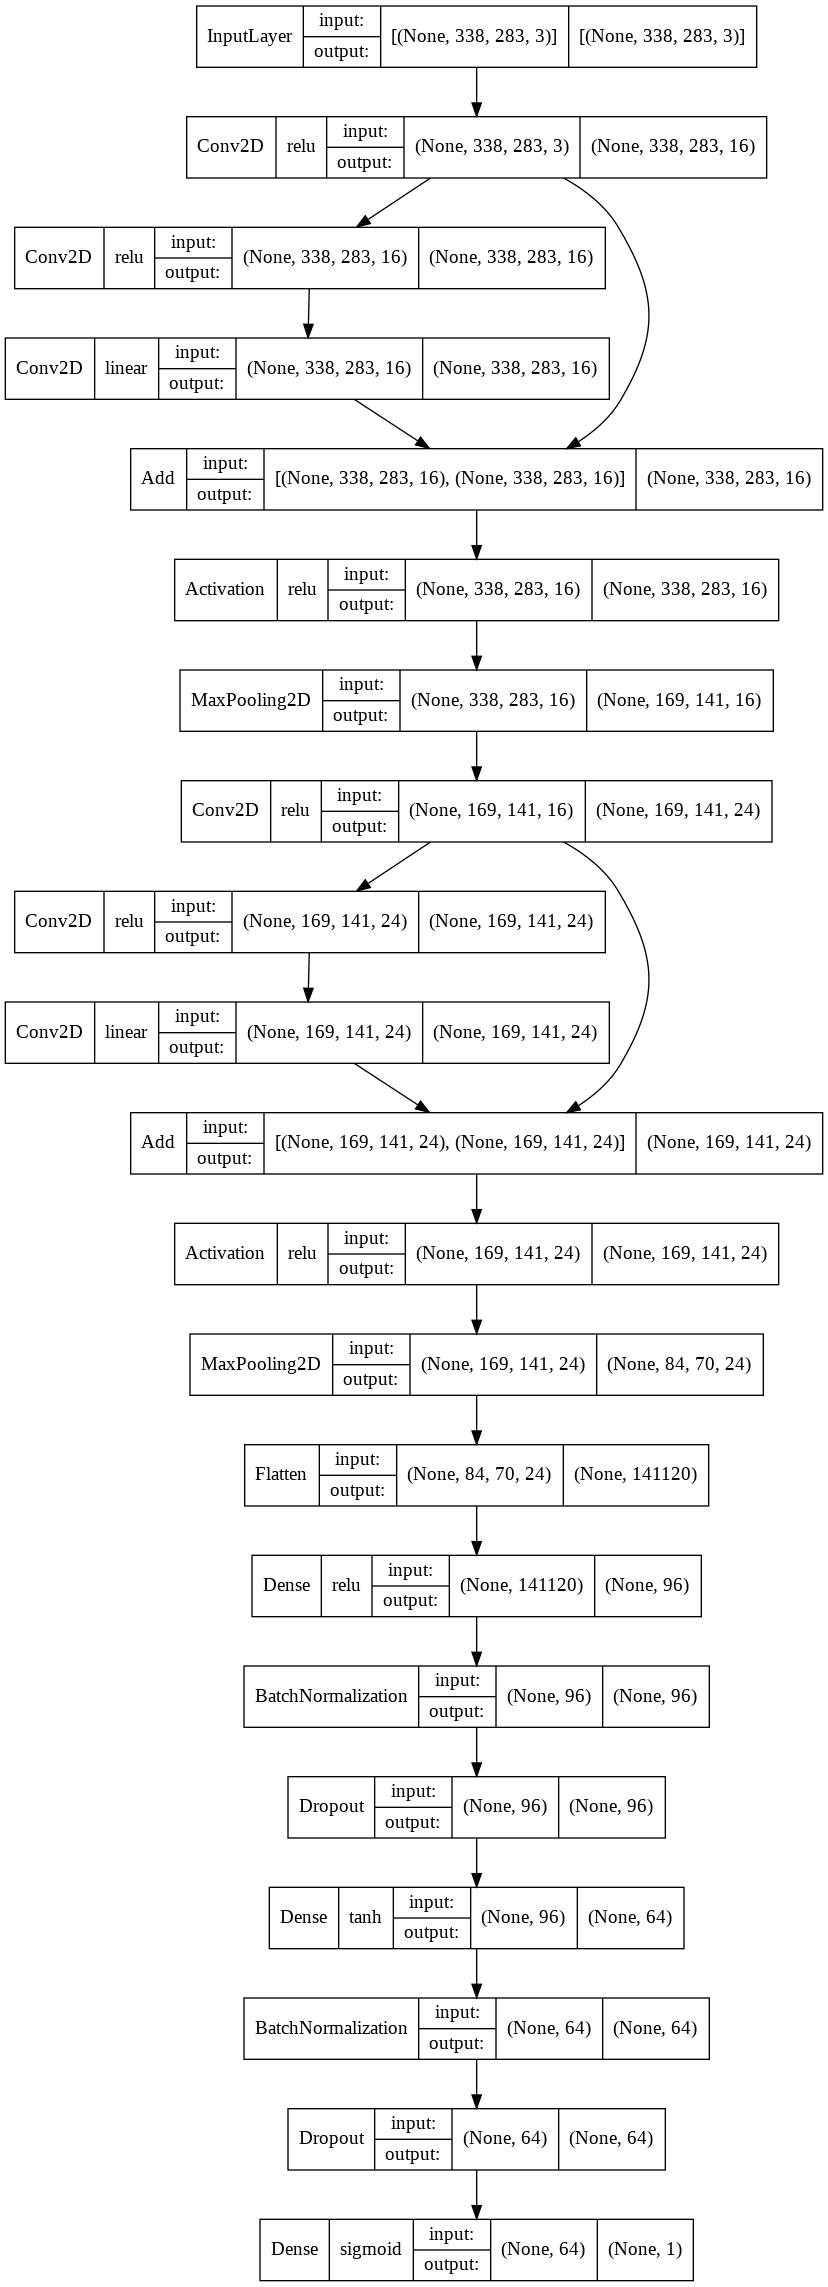

In [41]:
tf.keras.utils.set_random_seed(seed)
tf.config.experimental.enable_op_determinism()

if K.image_data_format() == 'channels_first':
    input_shape = (3, medianWidth, medianHeight)
else:
    input_shape = (medianWidth, medianHeight, 3)

inputs = keras.Input(input_shape)

x = Conv2D(filters=16, kernel_size=2, activation='relu', padding='same')(inputs)
fx = Conv2D(filters=16, kernel_size=3, activation='relu', padding='same')(x)
fx = Conv2D(filters=16, kernel_size=3, padding='same')(fx)
x = Add()([x, fx])
x = Activation('relu')(x)
x = MaxPool2D(strides=2, pool_size=(2,2))(x)

x = Conv2D(filters=24, kernel_size=2, activation='relu', padding='same')(x)
fx = Conv2D(filters=24, kernel_size=3, activation='relu', padding='same')(x)
fx = Conv2D(filters=24, kernel_size=3, padding='same')(fx)
x = Add()([x, fx])
x = Activation('relu')(x)
x = MaxPool2D(strides=2, pool_size=(2,2))(x)


x = Flatten()(x)
x = Dense(96, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.40)(x)
x = Dense(64, activation='tanh')(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.40)(x)
output = Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=output)

model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

print(model.summary())
print()
tf.keras.utils.plot_model(model, show_shapes = True, show_layer_names = False, show_layer_activations=True, expand_nested=True)

### Model 6 (Accuracy: 95.4%) (Simple CNN)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 338, 283, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 338, 283, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 169, 141, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 169, 141, 24)      3480      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 84, 70, 24)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 84, 70, 30)        6510

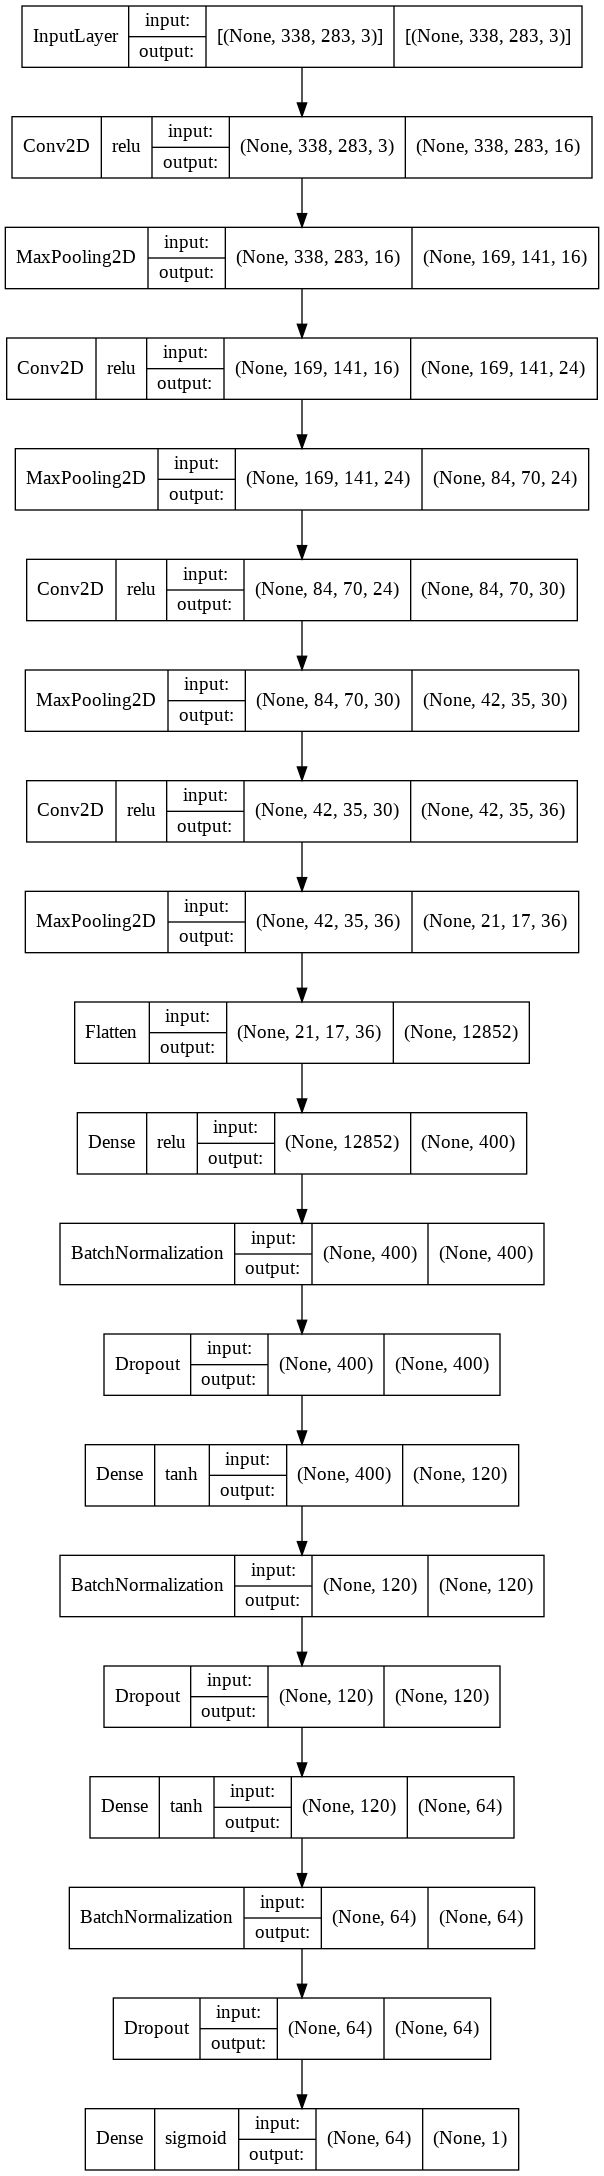

In [15]:
tf.keras.utils.set_random_seed(seed)
tf.config.experimental.enable_op_determinism()

if K.image_data_format() == 'channels_first':
    input_shape = (3, medianWidth, medianHeight)
else:
    input_shape = (medianWidth, medianHeight, 3)

inputs = keras.Input(input_shape)

x = Conv2D(filters=16, kernel_size=3, activation='relu', padding='same')(inputs)
x = MaxPool2D(strides=2, pool_size=(2,2))(x)

x = Conv2D(filters=24, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPool2D(strides=2, pool_size=(2,2))(x)

x = Conv2D(filters=30, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPool2D(strides=2, pool_size=(2,2))(x)

x = Conv2D(filters=36, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPool2D(strides=2, pool_size=(2,2))(x)

x = Flatten()(x)
x = Dense(400, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.40)(x)
x = Dense(120, activation='tanh')(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.40)(x)
x = Dense(64, activation='tanh')(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.40)(x)

#x = Dense(32, activation='relu')(x)
#x = BatchNormalization()(x)
#x = Dropout(rate=0.40)(x)

output = Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=output)

model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

print(model.summary())
print()
tf.keras.utils.plot_model(model, show_shapes = True, show_layer_names = False, show_layer_activations=True, expand_nested=True)

### Model 7 (Accuracy: 96.1%) (Simple CNN)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 338, 283, 3)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 338, 283, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 169, 141, 16)     0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 169, 141, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 84, 70, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 84, 70, 64)        1849

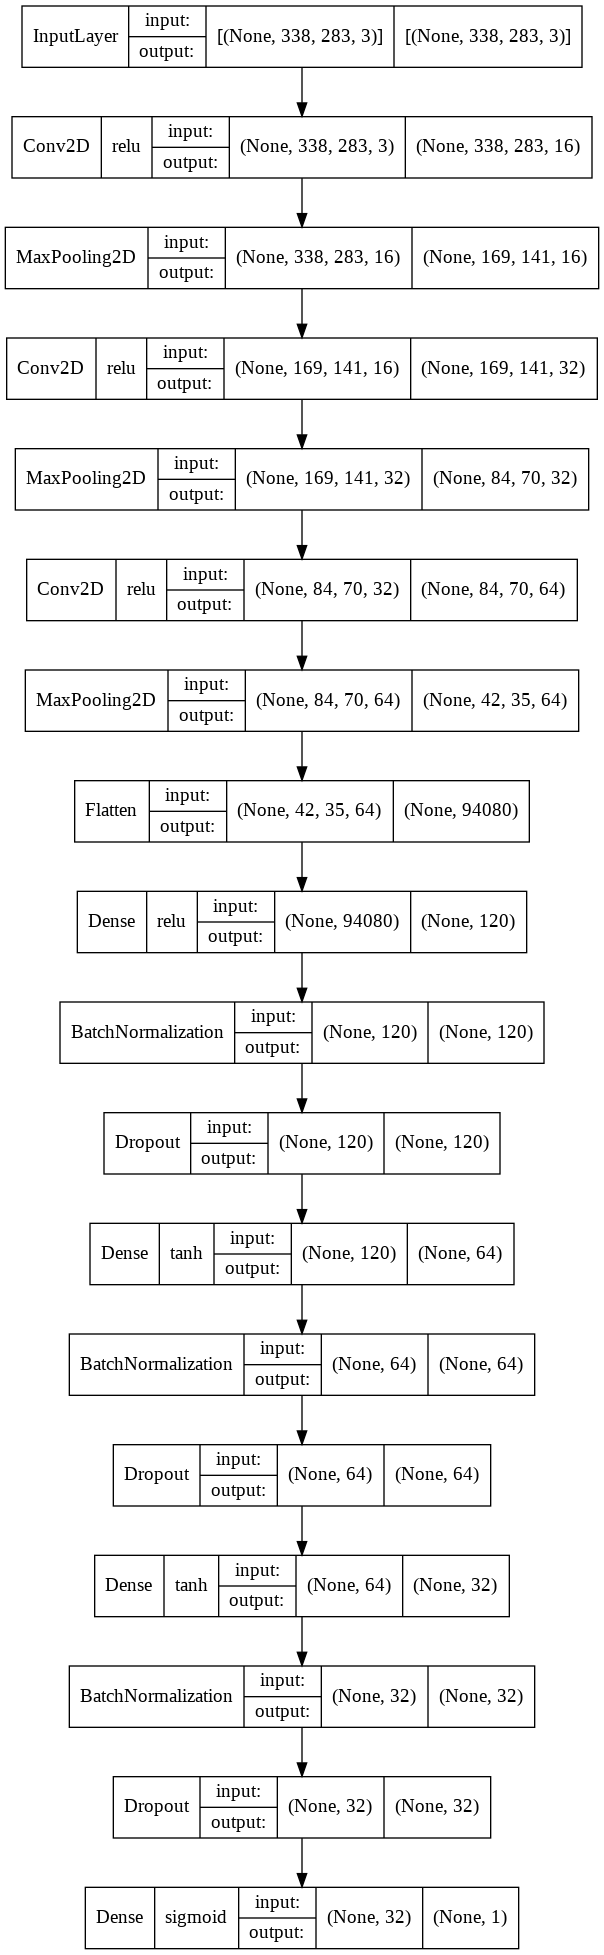

In [21]:
tf.keras.utils.set_random_seed(seed)
tf.config.experimental.enable_op_determinism()

if K.image_data_format() == 'channels_first':
    input_shape = (3, medianWidth, medianHeight)
else:
    input_shape = (medianWidth, medianHeight, 3)

inputs = keras.Input(input_shape)

x = Conv2D(filters=16, kernel_size=3, activation='relu', padding='same')(inputs)
x = MaxPool2D(strides=2, pool_size=(2,2))(x)

x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPool2D(strides=2, pool_size=(2,2))(x)

x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPool2D(strides=2, pool_size=(2,2))(x)

x = Flatten()(x)
x = Dense(120, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.40)(x)

x = Dense(64, activation='tanh')(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.40)(x)

x = Dense(32, activation='tanh')(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.40)(x)

output = Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=output)

model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

print(model.summary())
print()
tf.keras.utils.plot_model(model, show_shapes = True, show_layer_names = False, show_layer_activations=True, expand_nested=True)

### Model 8 (Accuracy: 96.2%) (Simple CNN)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 338, 283, 3)]     0         
                                                                 
 conv2d_13 (Conv2D)          (None, 338, 283, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 169, 141, 32)     0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 169, 141, 48)      13872     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 84, 70, 48)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 84, 70, 64)        2771

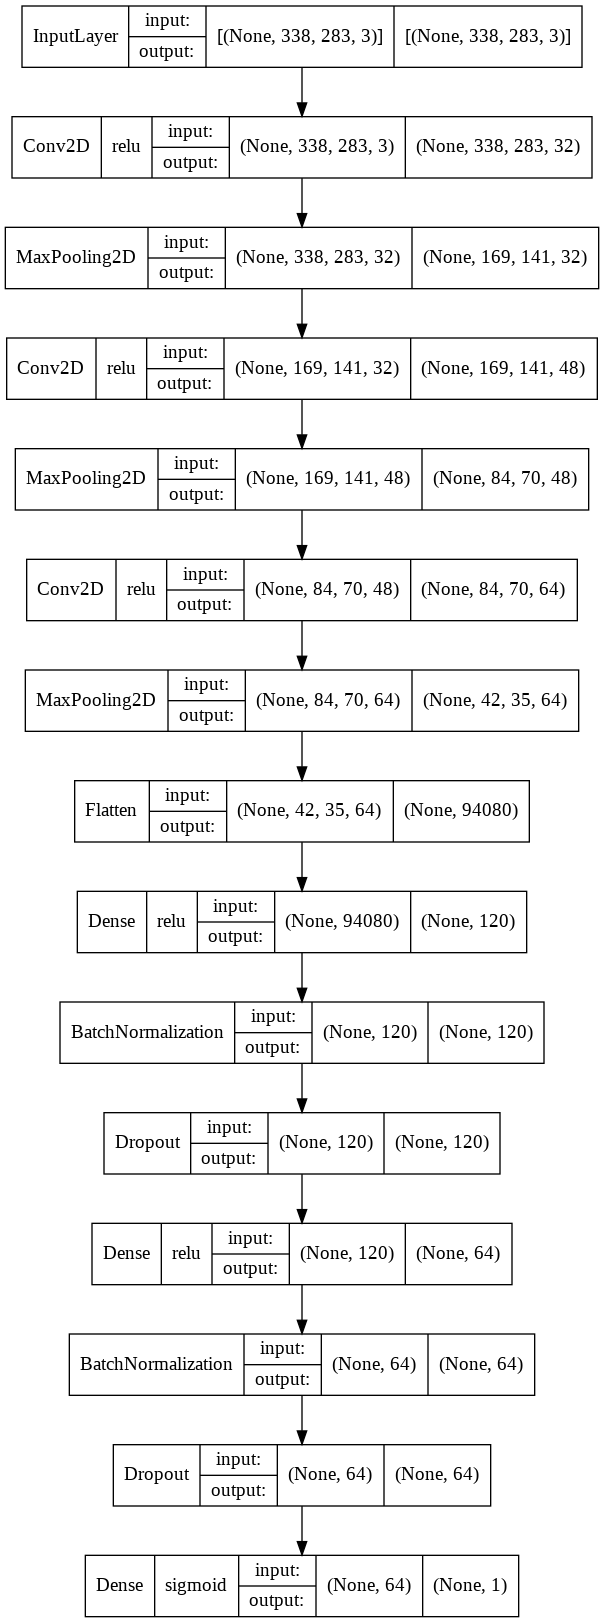

In [27]:
tf.keras.utils.set_random_seed(seed)
tf.config.experimental.enable_op_determinism()

if K.image_data_format() == 'channels_first':
    input_shape = (3, medianWidth, medianHeight)
else:
    input_shape = (medianWidth, medianHeight, 3)

inputs = keras.Input(input_shape)

x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(inputs)
x = MaxPool2D(strides=2, pool_size=(2,2))(x)

x = Conv2D(filters=48, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPool2D(strides=2, pool_size=(2,2))(x)

x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPool2D(strides=2, pool_size=(2,2))(x)

x = Flatten()(x)
x = Dense(120, activation='relu')(x)  #Decrease neurons here?
x = BatchNormalization()(x)
x = Dropout(rate=0.35)(x)

x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.35)(x)

output = Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=output)

model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

print(model.summary())
print()
tf.keras.utils.plot_model(model, show_shapes = True, show_layer_names = False, show_layer_activations=True, expand_nested=True)

### Model 9 (Accuracy: 96.4%) (CNN with Concatenation)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 338, 283, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 338, 283, 16  208         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_9 (Conv2D)              (None, 338, 283, 16  448         ['input_2[0][0]']                
                                )                                                           

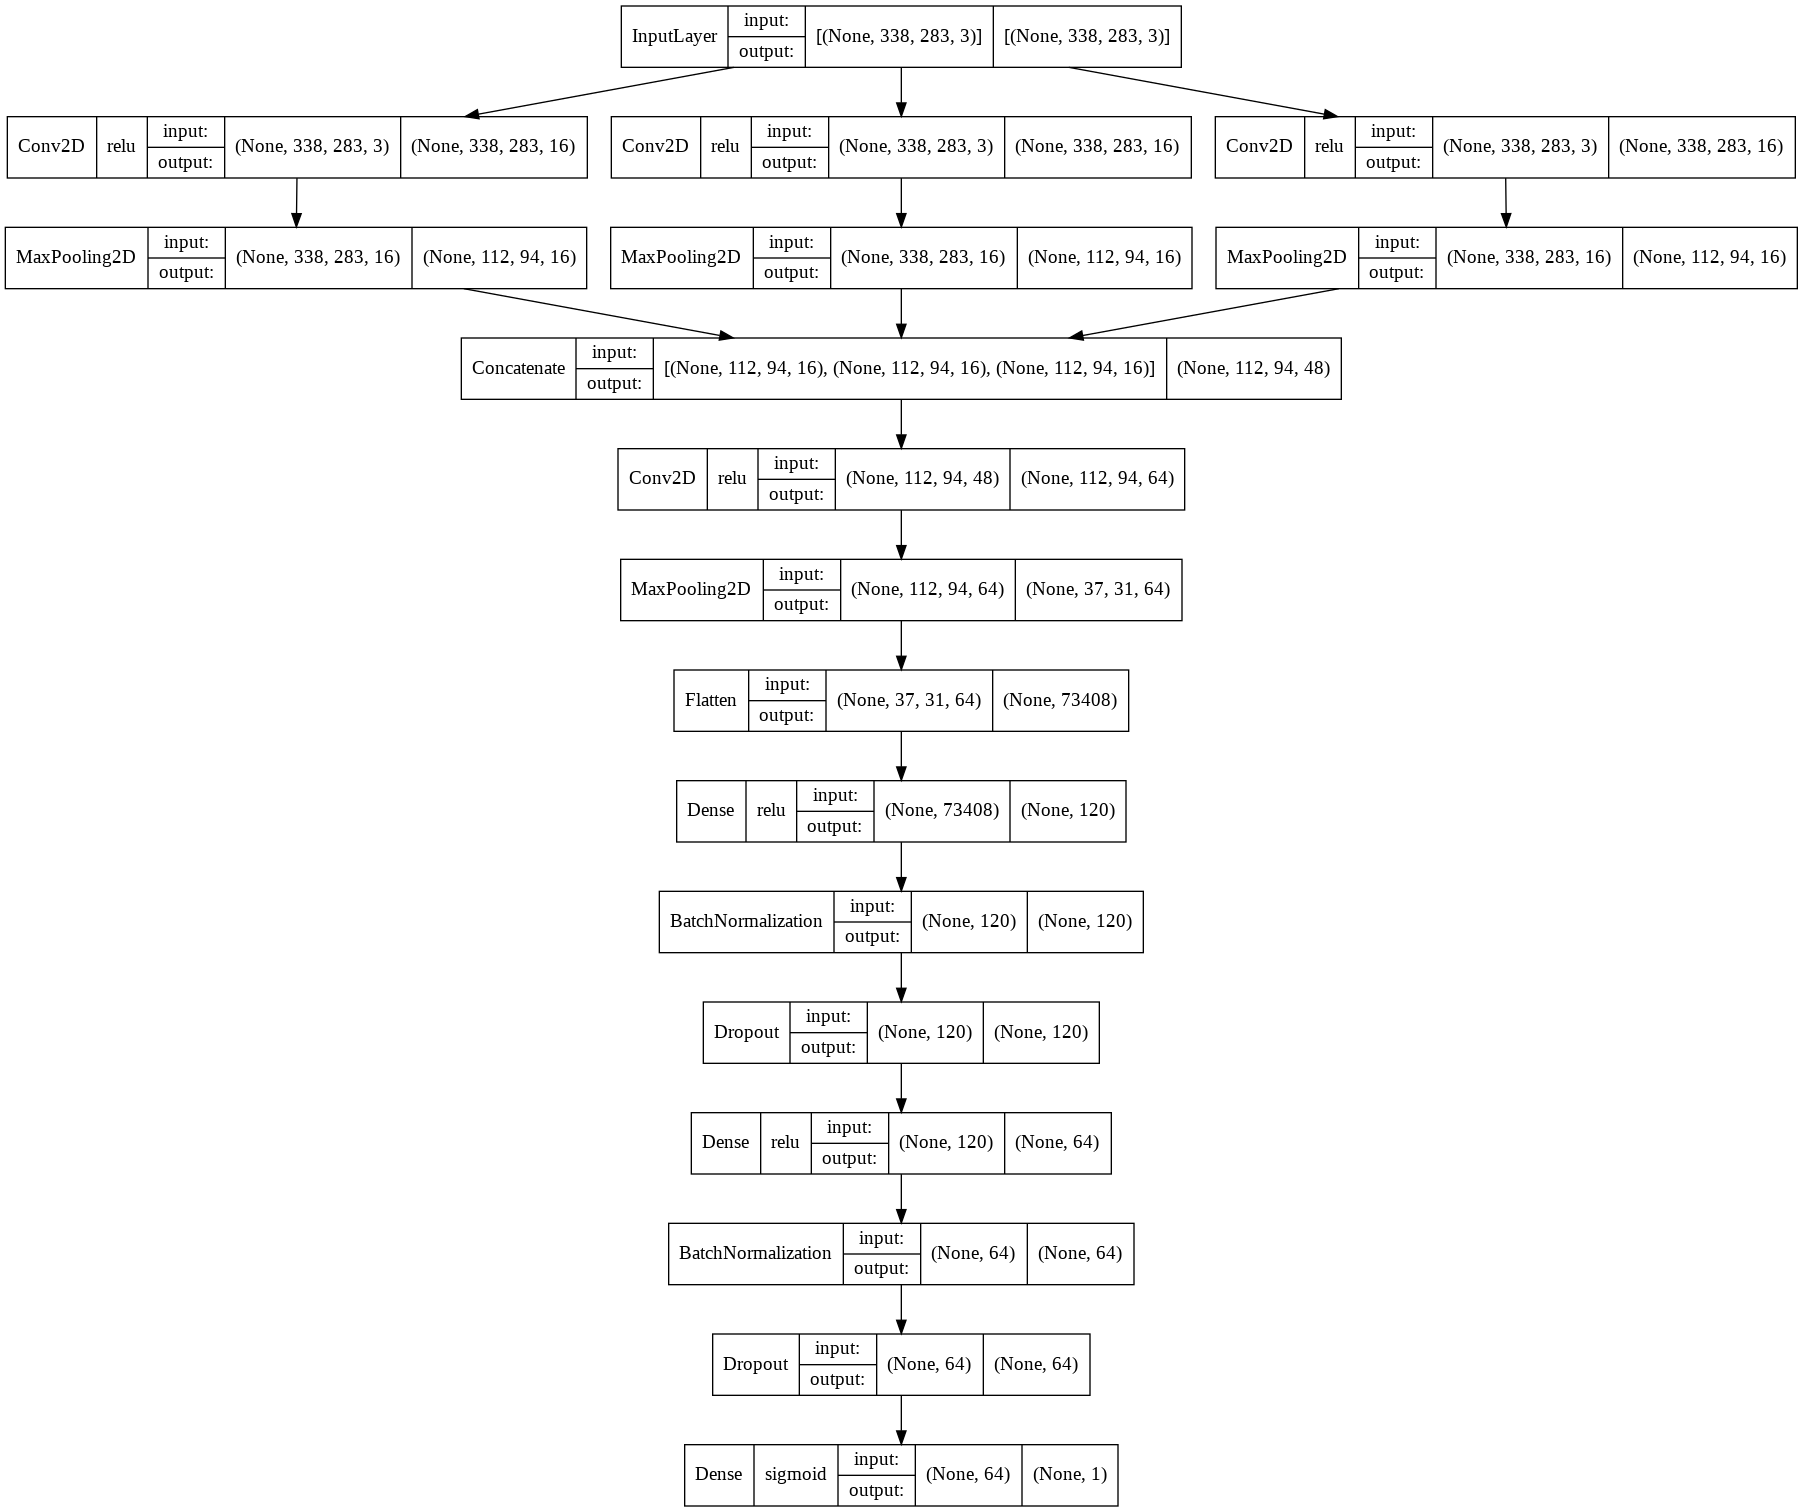

In [14]:
tf.keras.utils.set_random_seed(seed)
tf.config.experimental.enable_op_determinism()

if K.image_data_format() == 'channels_first':
    input_shape = (3, medianWidth, medianHeight)
else:
    input_shape = (medianWidth, medianHeight, 3)

inputs = keras.Input(input_shape)

x1 = Conv2D(filters=16, kernel_size=2, activation='relu', padding='same')(inputs)
x1 = MaxPool2D(pool_size=(3,3))(x1)

x2 = Conv2D(filters=16, kernel_size=3, activation='relu', padding='same')(inputs)
x2 = MaxPool2D(pool_size=(3,3))(x2)

x3 = Conv2D(filters=16, kernel_size=5, activation='relu', padding='same')(inputs)
x3 = MaxPool2D(pool_size=(3,3))(x3)

x = Concatenate()([x1, x2, x3])

x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(3,3))(x)

x = Flatten()(x)
x = Dense(120, activation='relu')(x) 
x = BatchNormalization()(x)
x = Dropout(rate=0.40)(x)

x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.40)(x)

output = Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=output)

model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

print(model.summary())
print()
tf.keras.utils.plot_model(model, show_shapes = True, show_layer_names = False, show_layer_activations=True, expand_nested=True)

### Model 10 (Accuracy: 96.8%) (CNN with Concatenation)

try same with smaller pool size...?

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 338, 283, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 338, 283, 16  208         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 338, 283, 16  448         ['input_1[0][0]']                
                                )                                                             

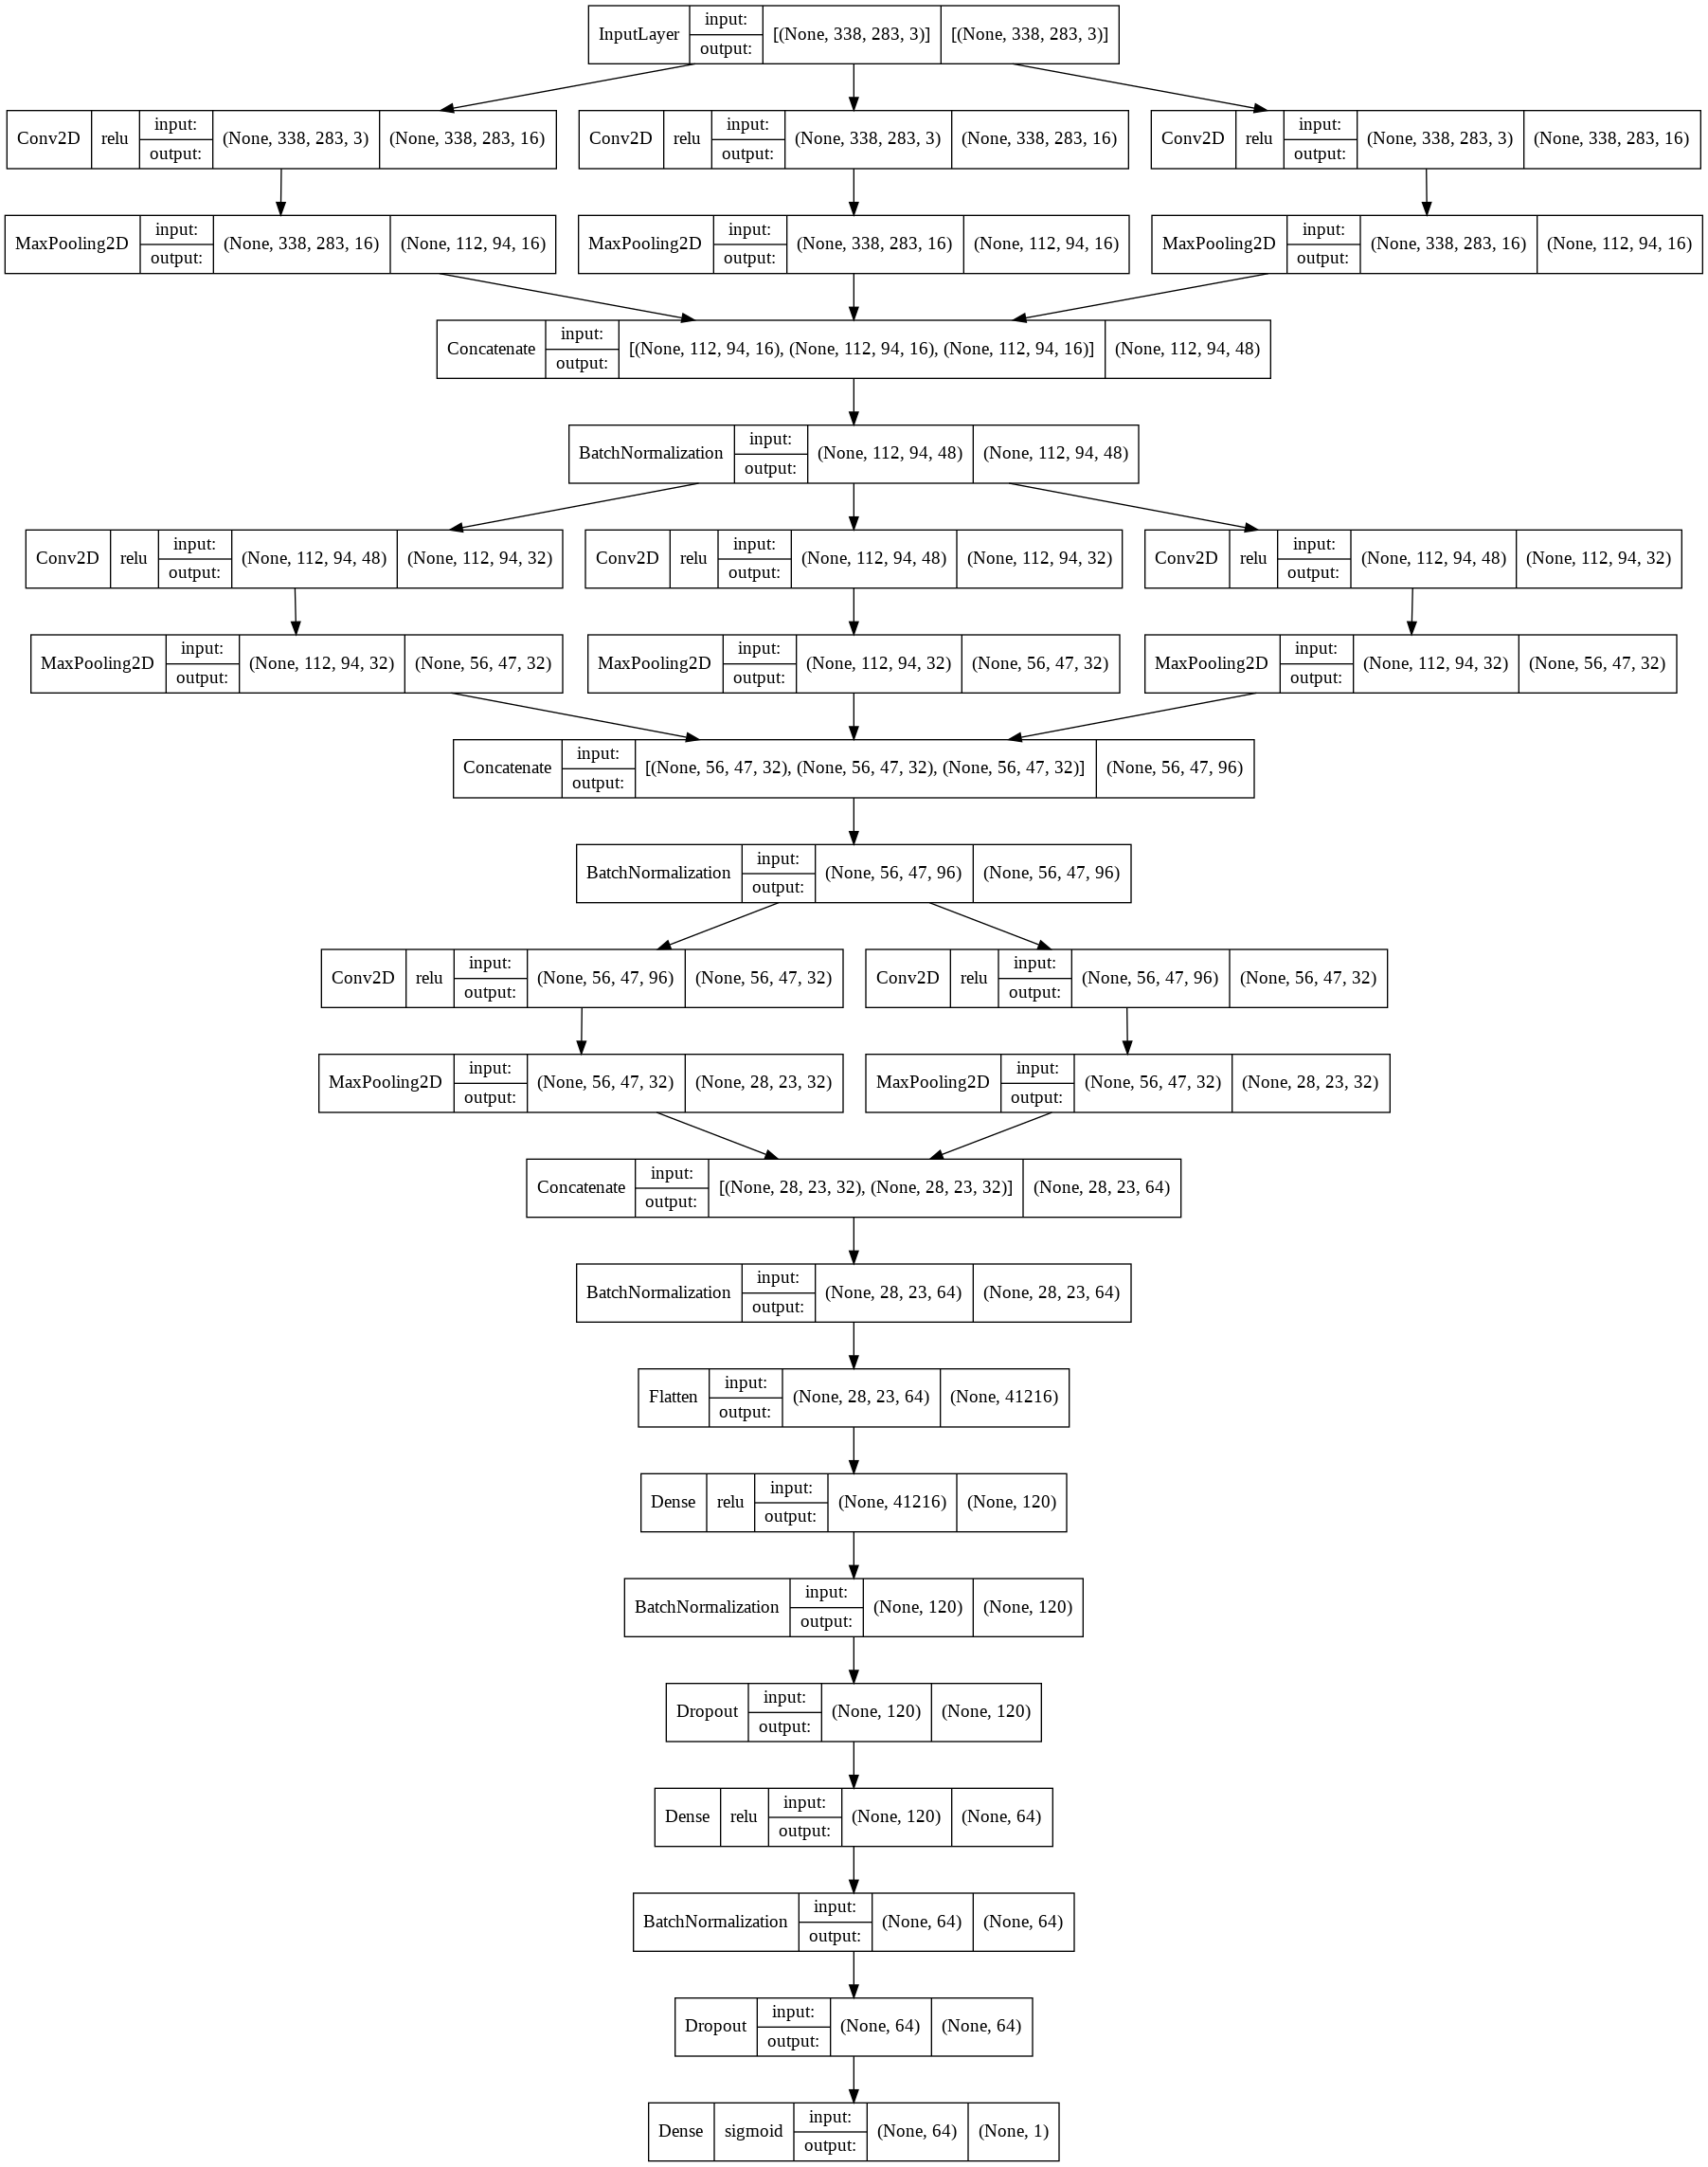

In [11]:
tf.keras.utils.set_random_seed(seed)
tf.config.experimental.enable_op_determinism()

if K.image_data_format() == 'channels_first':
    input_shape = (3, medianWidth, medianHeight)
else:
    input_shape = (medianWidth, medianHeight, 3)

inputs = keras.Input(input_shape)

x1 = Conv2D(filters=16, kernel_size=2, activation='relu', padding='same')(inputs)
x1 = MaxPool2D(pool_size=(3,3))(x1)

x2 = Conv2D(filters=16, kernel_size=3, activation='relu', padding='same')(inputs)
x2 = MaxPool2D(pool_size=(3,3))(x2)

x3 = Conv2D(filters=16, kernel_size=5, activation='relu', padding='same')(inputs)
x3 = MaxPool2D(pool_size=(3,3))(x3)

x = Concatenate()([x1, x2, x3])
x = BatchNormalization()(x)

x1 = Conv2D(filters=32, kernel_size=2, activation='relu', padding='same')(x)
x1 = MaxPool2D(pool_size=(2,2))(x1)

x2 = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x2 = MaxPool2D(pool_size=(2,2))(x2)

x3 = Conv2D(filters=32, kernel_size=5, activation='relu', padding='same')(x)
x3 = MaxPool2D(pool_size=(2,2))(x3)

x = Concatenate()([x1, x2, x3])
x = BatchNormalization()(x)

x1 = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x1 = MaxPool2D(pool_size=(2,2))(x1)

x2 = Conv2D(filters=32, kernel_size=5, activation='relu', padding='same')(x)
x2 = MaxPool2D(pool_size=(2,2))(x2)

x = Concatenate()([x1, x2])
x = BatchNormalization()(x)

x = Flatten()(x)
x = Dense(120, activation='relu')(x) 
x = BatchNormalization()(x)
x = Dropout(rate=0.40)(x)

x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.40)(x)

output = Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=output)

model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

print(model.summary())
print()
tf.keras.utils.plot_model(model, show_shapes = True, show_layer_names = False, show_layer_activations=True, expand_nested=True)

## Train/Validate Model

In [42]:
train_generator = generator.flow_from_directory(
    train_data_dir,
    target_size=(medianWidth, medianHeight),
    batch_size=batch_size,
    class_mode='binary',
    seed=seed)

validation_generator = generator.flow_from_directory(
    validate_data_dir,
    target_size=(medianWidth, medianHeight),
    batch_size=validation_batch_size,
    class_mode='binary',
    seed=seed)

earlystopping = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", 
                                        patience=5, restore_best_weights = True)

history = model.fit(
    x=train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validate_samples // validation_batch_size,
    callbacks=[earlystopping])

model.save_weights(weights_file)

Found 3220 images belonging to 2 classes.
Found 690 images belonging to 2 classes.
Epoch 1/15
100/100 [==============================] - 787s 8s/step - loss: 0.6397 - accuracy: 0.6857 - val_loss: 0.4077 - val_accuracy: 0.8368
Epoch 2/15
100/100 [==============================] - 783s 8s/step - loss: 0.3363 - accuracy: 0.8664 - val_loss: 0.7887 - val_accuracy: 0.5735
Epoch 3/15
100/100 [==============================] - 780s 8s/step - loss: 0.1926 - accuracy: 0.9294 - val_loss: 0.2920 - val_accuracy: 0.8750
Epoch 4/15
100/100 [==============================] - 772s 8s/step - loss: 0.0973 - accuracy: 0.9664 - val_loss: 0.1381 - val_accuracy: 0.9647
Epoch 5/15
100/100 [==============================] - 770s 8s/step - loss: 0.0789 - accuracy: 0.9765 - val_loss: 0.5388 - val_accuracy: 0.7941
Epoch 6/15
100/100 [==============================] - 773s 8s/step - loss: 0.0640 - accuracy: 0.9762 - val_loss: 0.7701 - val_accuracy: 0.7103
Epoch 7/15
100/100 [==============================] - 767s 

In [ ]:
#print(history.history)
print()
print('Training accuracy vs epoch:', history.history['accuracy'])
print()
print('Validation accuracy vs epoch:', history.history['val_accuracy'])


Training accuracy vs epoch: [0.7252195477485657, 0.8811166882514954, 0.9278544783592224, 0.9711417555809021, 0.971455454826355, 0.9717691540718079, 0.9890213012695312, 0.9890213012695312, 0.99153071641922, 0.9846298694610596]

Validation accuracy vs epoch: [0.8147059082984924, 0.8720588088035583, 0.8823529481887817, 0.9558823704719543, 0.9558823704719543, 0.9058823585510254, 0.9588235020637512, 0.8338235020637512, 0.9720588326454163, 0.9529411792755127]


Text(0.5, 1.0, 'Accuracy of Model vs Epoch Number')

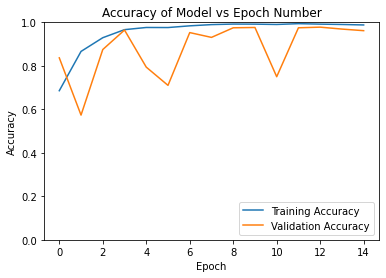

In [43]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title("Accuracy of Model vs Epoch Number")


Text(0.5, 1.0, 'Loss of Model vs Epoch Number')

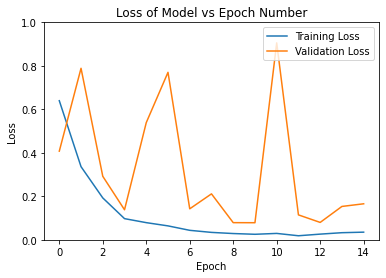

In [44]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')
plt.title("Loss of Model vs Epoch Number")

## Test Model

In [45]:
test_generator = generator.flow_from_directory(
    test_data_dir,
    target_size=(medianWidth, medianHeight),
   batch_size=validation_batch_size,
    class_mode='binary',
    seed=seed,
    shuffle=False)

test_results = model.evaluate(test_generator)

Found 690 images belonging to 2 classes.
21/21 [==============================] - 47s 2s/step - loss: 0.1375 - accuracy: 0.9565


In [46]:
print("Accuracy on test set: ", test_results[1])

Accuracy on test set:  0.95652174949646


In [47]:
y_pred = model.predict(test_generator) # Predict prob and get Class Indices
classes = test_generator.class_indices  # Map of Indices to Class name

labels = test_generator.labels
predictions = []
for prediction in y_pred:
  if prediction < 0.5:
    predictions.append('cancer')
  else:
    predictions.append('healthy')
true_labels = []
for label in labels:
  if label == 0:
    true_labels.append('cancer')
  else:
    true_labels.append('healthy')

In [48]:
(stats, labels) = summaryStatistics(true_labels, predictions)
for i in range(len(stats)):
  print(labels[i], ': ', stats[i])

True Positive :  373
False Negative :  19
False Positive :  11
True Negative :  287
Accuracy :  0.9565217391304348
Precision :  0.9713541666666666
Sensitivity (True Positive Rate) :  0.951530612244898
Specificity (True Negative Rate) :  0.9630872483221476
False Negative Rate :  0.04846938775510204
False Positive Rate :  0.03691275167785235
Null Error Rate :  0.5681159420289855


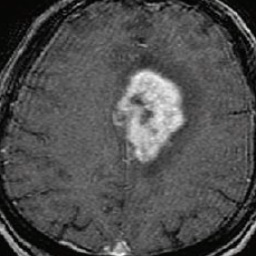

Class Predicted ----  healthy


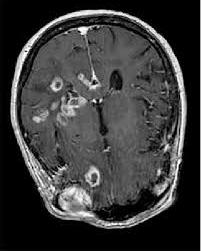

Class Predicted ----  healthy


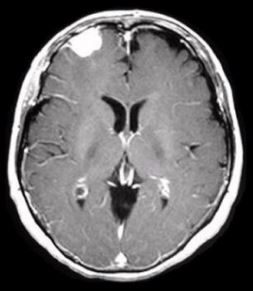

Class Predicted ----  healthy


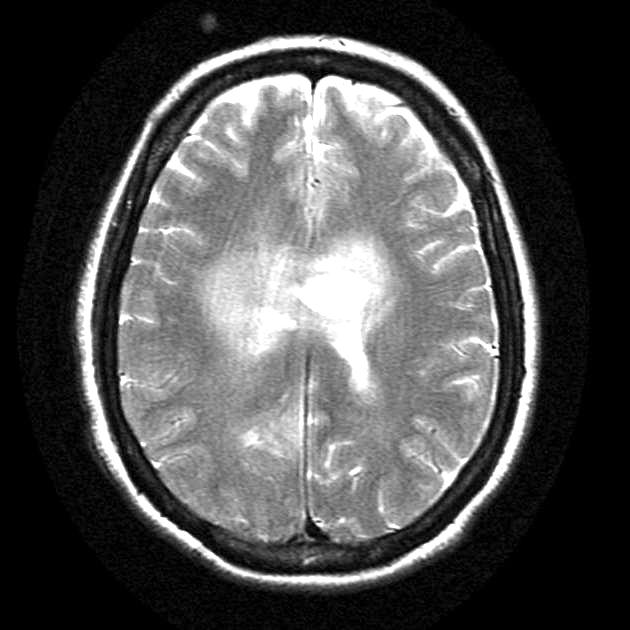

Class Predicted ----  healthy


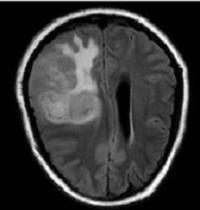

Class Predicted ----  healthy


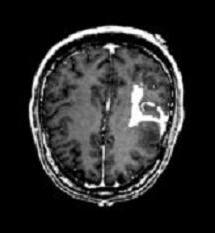

Class Predicted ----  healthy


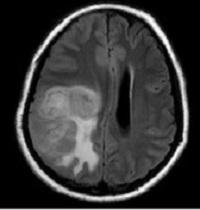

Class Predicted ----  healthy


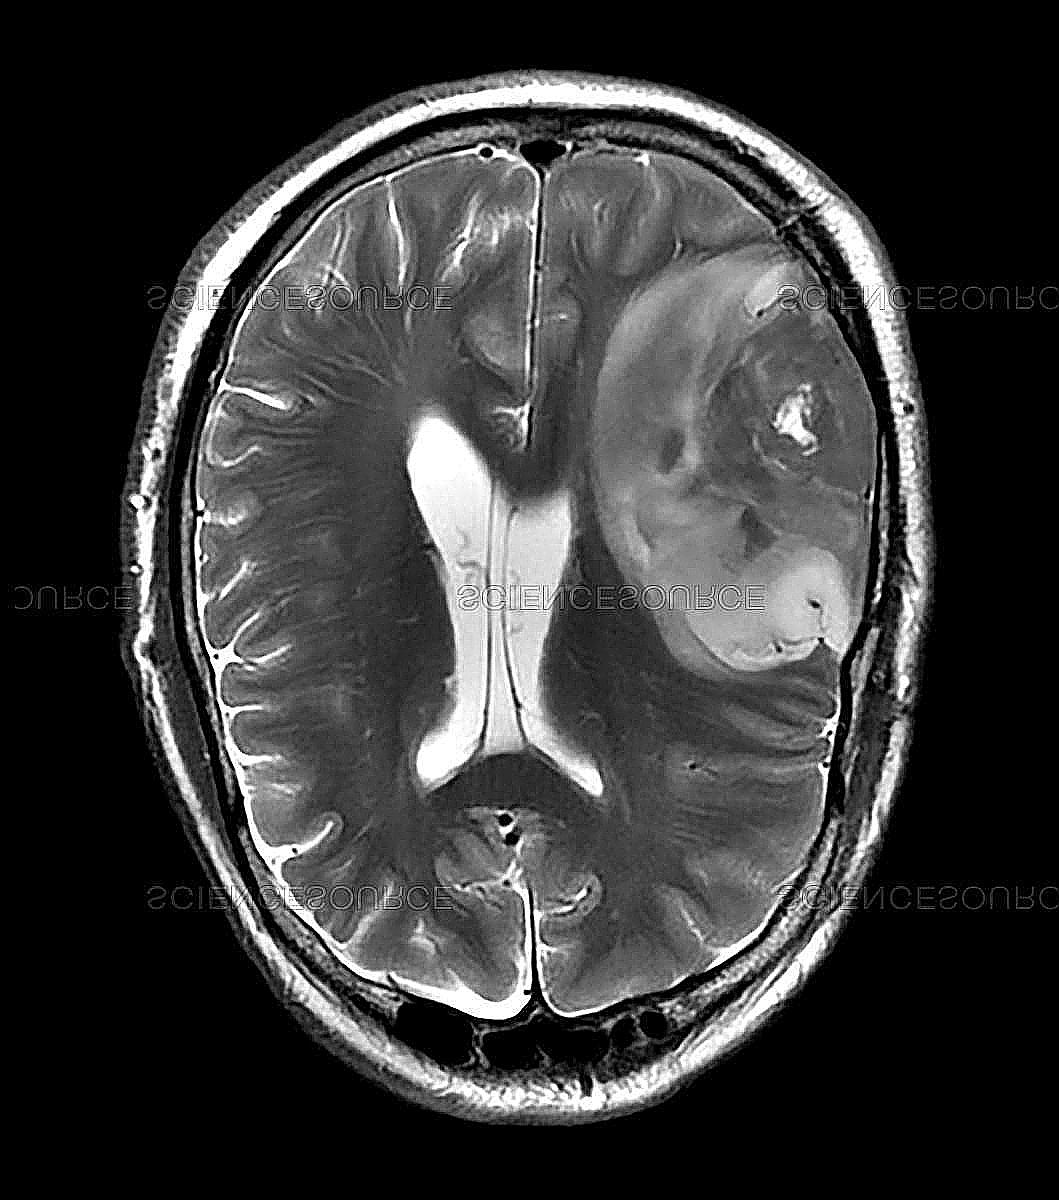

Class Predicted ----  healthy


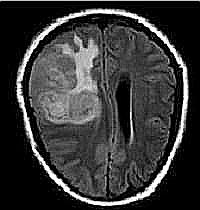

Class Predicted ----  healthy


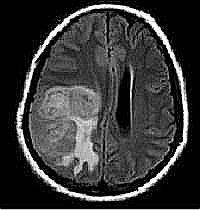

Class Predicted ----  healthy


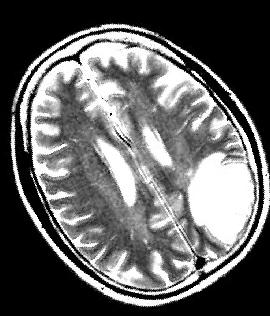

Class Predicted ----  healthy


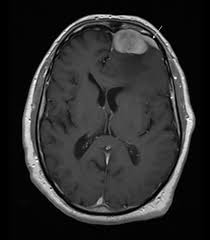

Class Predicted ----  healthy


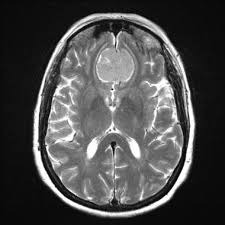

Class Predicted ----  healthy


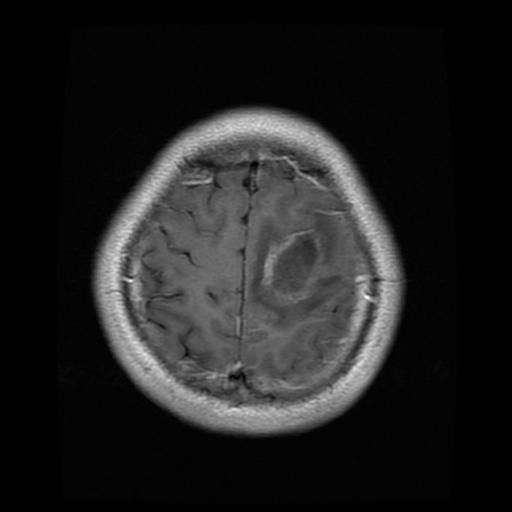

Class Predicted ----  healthy


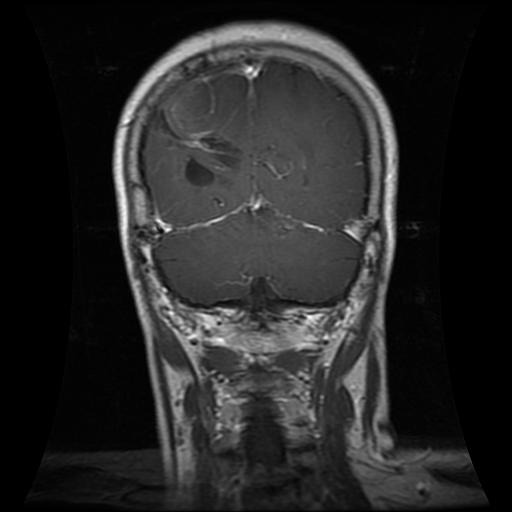

Class Predicted ----  healthy


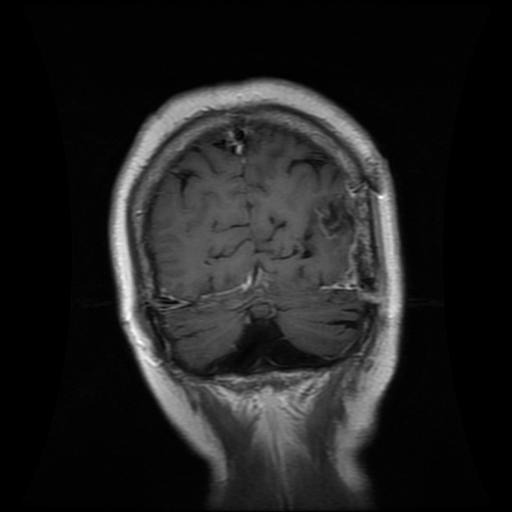

Class Predicted ----  healthy


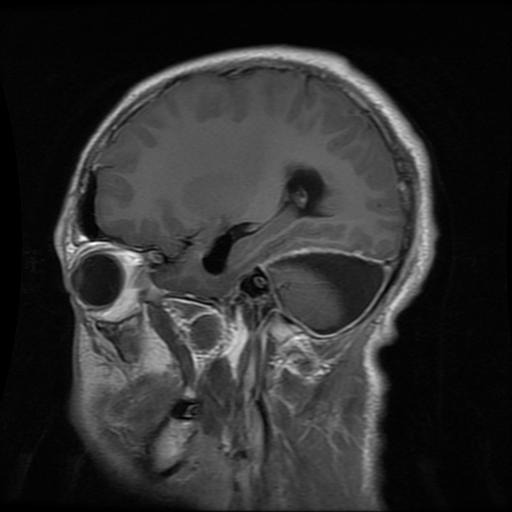

Class Predicted ----  healthy


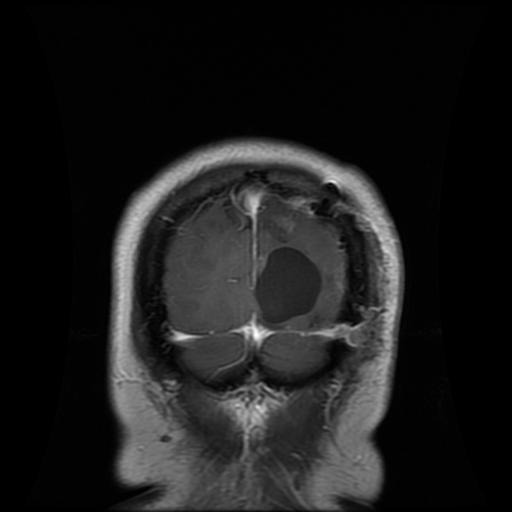

Class Predicted ----  healthy


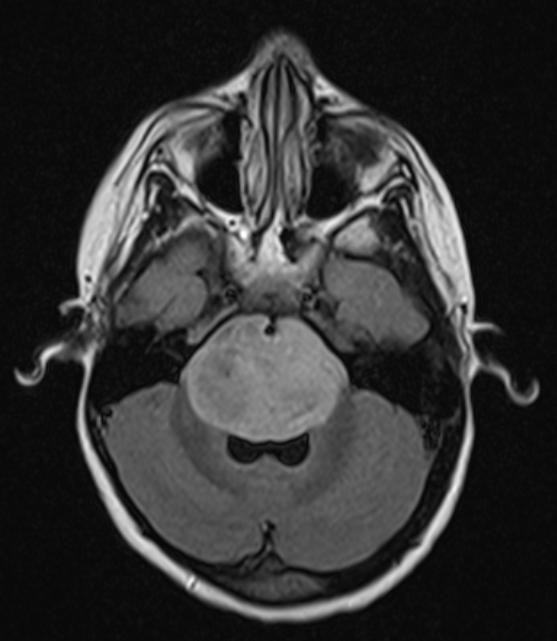

Class Predicted ----  healthy


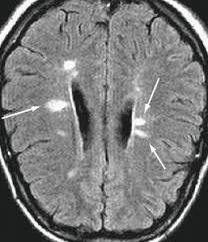

Class Predicted ----  cancer


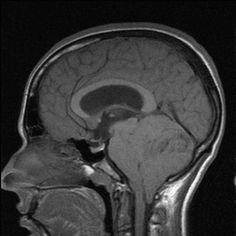

Class Predicted ----  cancer


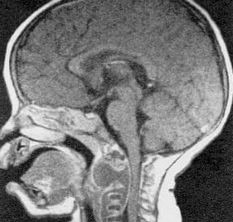

Class Predicted ----  cancer


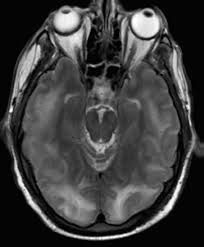

Class Predicted ----  cancer


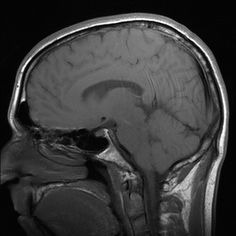

Class Predicted ----  cancer


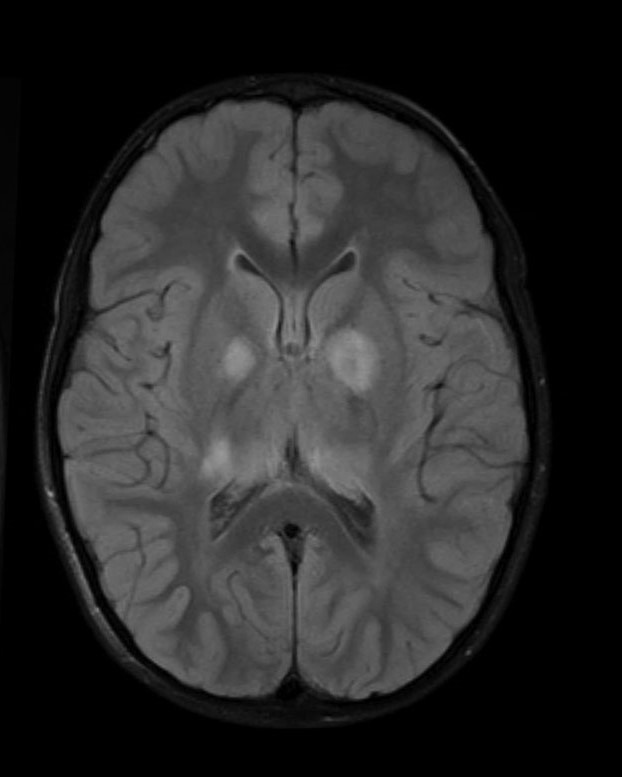

Class Predicted ----  cancer


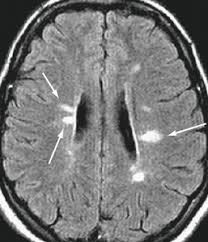

Class Predicted ----  cancer


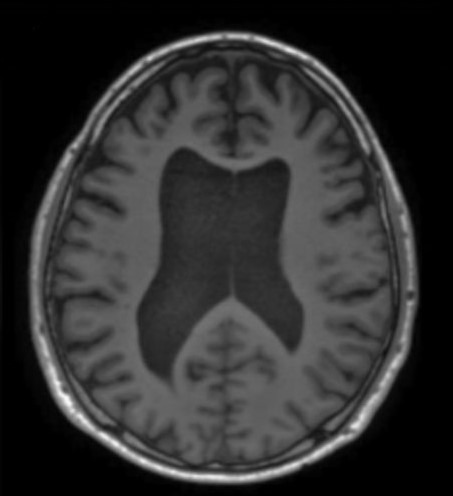

Class Predicted ----  cancer


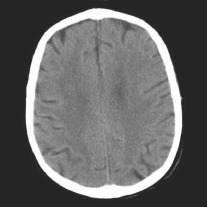

Class Predicted ----  cancer


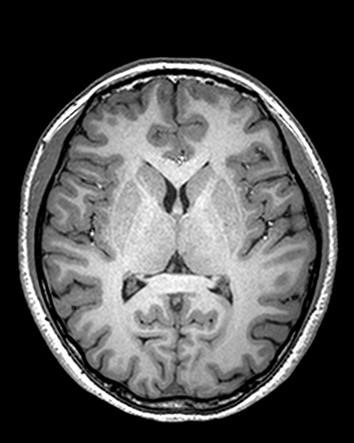

Class Predicted ----  cancer


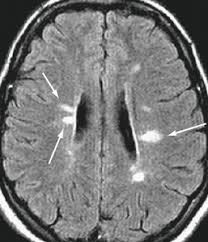

Class Predicted ----  cancer


In [49]:
from keras.preprocessing import image

# Show images model failed to predict correctly and predicted label
paths = test_generator.filenames
for i in range(len(predictions)):
  if (predictions[i] != true_labels[i]):
    img = image.load_img(os.path.join('data', 'test', paths[i]))       
    img = image.img_to_array(img)
    from google.colab.patches import cv2_imshow
    cv2_imshow(img)
    print('Class Predicted ---- ', predictions[i])